# Lab: Time Evolution and Variational Algorithm

Wenyang Qian, April 26, 1 PM - 3 PM

Qiskit Lab Section (two hours) for Quantum Computing Lectures at UCLA

<div class="alert alert-block alert-success">

**Readme**  
    
There are 17 exercises (marked in Green) in total in this Jupyter notebook. These questions will teach you on

Part 0. Basics in Qiskit to perform time evolution and expectation measurement (Exercises 1-6)

Part 1. Real-time evolution with the Ising model (Exercises 7-10)

Part 2. Variational Quantum Eigensolvers from scratch to solve the Maxcut Problem (Exercises 11-17)
    
Most of these exercises are straightforward, with solutions in one or two lines. Basically, you need to fill the space between:

"
##### ==================================
\# Write your solution in here.  



##### ==================================
"

This is not a test so be feel free to ask your mentors and discss with your classmates if you have questions.

We really hope you enjoy learning quantum computing with Qiskit. If you have any question after the class, be free to email qian dot wenyang at usc dot es.
    
</div>

In [109]:
# make sure these libraries are install, if not, use pip to install them

# !pip install qiskit==0.44
# !pip install qiskit-aer==0.12
# !pip install qiskit_algorithms==0.2
# !pip install matplotlib
# !pip install pylatexenc
# !pip install numpy
# !pip install networkx
# !pip install scipy

In [145]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from time import time as current_time
from scipy import linalg as LA

from qiskit import execute, Aer, transpile
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate, TwoLocal
from qiskit.quantum_info import Pauli, SparsePauliOp, Statevector
from qiskit.tools.visualization import plot_histogram, plot_distribution
from qiskit.primitives import Estimator, Sampler
from qiskit.synthesis import LieTrotter, SuzukiTrotter

import qiskit_aer
import qiskit
import qiskit_algorithms
import qiskit.tools.jupyter

%qiskit_version_table

## Part 0. Preparation

In this part, you will learn the basic tools to construct operators $\hat{H}$, simulate quantum circuit $\exp(-i\hat{H}t)$ in real time, and evaluate observable such as $\langle \hat{O} \rangle$.

### 0.1. Pauli operations in Qiskit

In Qiskit, building the Pauli strings to represent the Hamiltonian is usually the first step. Typically, we can use the *SparsePauliOp* class. You can read more about *SparsePauliOp* class [here](https://qiskit.org/documentation/stubs/qiskit.quantum_info.SparsePauliOp.html)

We start by writing the standard **Pauli matrices** in Qiskit. Make sure you check these single-qubit Pauli operators in matrix form and it should agree with your expectation.

In [20]:
X = SparsePauliOp('X')
Y = SparsePauliOp('Y')
Z = SparsePauliOp('Z')
I = SparsePauliOp('I')

print("Pauli-X operator:")
print(X.to_matrix())
print("\nPauli-Y operator:")
print(Y.to_matrix())
print("\nPauli-Z operator:")
print(Z.to_matrix())
print("\nPauli-I operator:")
print(I.to_matrix())

Pauli-X operator:
[[0.+0.j 1.+0.j]
 [1.+0.j 0.+0.j]]

Pauli-Y operator:
[[0.+0.j 0.-1.j]
 [0.+1.j 0.+0.j]]

Pauli-Z operator:
[[ 1.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j]]

Pauli-I operator:
[[1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]


These are single-qubit Pauli matrices, which are the building blocks of more complicated Pauli objects (typically over multiple qubits).  

To build more interesting Pauli operators, we need the following the Pauli arithmetic operations.

(a) **Multiple-qubit Pauli Operators**. You need represent tensor product of Paulis with $^$ symbol. See the examples below.

Example 1: 4-qubit tensor product, $I \otimes X\otimes Y \otimes Z$

In [21]:
I^X^Y^Z

SparsePauliOp(['IXYZ'],
              coeffs=[1.+0.j])

Note, Qiskit used a reversed notation, so it is actually $I_3 \otimes X_2\otimes Y_1 \otimes Z_0$. (PS: Typically if you use a consistently, you can decide to whether to invert your measured outcomes at the end of simulation or not.)

(b) **Scalar Product**. You will need to use the $*$ symbol between the coefficient and the Pauli.

Example 2: 4-qubit tensor product, $4 I \otimes X\otimes Y \otimes Z$

In [22]:
4*I^X^Y^Z

SparsePauliOp(['IXYZ'],
              coeffs=[4.+0.j])

(c) **Linear Combinations of Pauli Operators**. You will use the $+$ symbol to write a linear combination of the Pauli operators. Only Pauli operators of the same number of qubits can be joined. Different components must bed grouped with parenthesis.

Example 3: 4-qubit linear combinations, $X\otimes X\otimes I \otimes I + 2I \otimes Y\otimes  Y\otimes I + 3I \otimes I\otimes  Z\otimes Z$

In [23]:
(X^X^I^I) + 2*(I^Y^Y^I) + 3*(I^I^Z^Z)

SparsePauliOp(['XXII', 'IYYI', 'IIZZ'],
              coeffs=[1.+0.j, 2.+0.j, 3.+0.j])

(d) **Product of Pauli Operators**. *SparsePauliOp* class really shines when you want to compute qubitwise product of pauli operators. You will use the $@$ symbol. 

In the example below, you can see it supports algebraic expression and knows Pauli matrix properties. The final result can be further simplified with *.simplify()* method. 

In [24]:
# contructing an interesting Pauli operator

op1 = X^Y
op2 = Y^X

res = op1@op1 + op2@op2 + op1@op2 + op2@op1

print(res)

SparsePauliOp(['II', 'II', 'ZZ', 'ZZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


In [25]:
print('\nSum of product after .simplify()')
print(res.simplify())


Sum of product after .simplify()
SparsePauliOp(['II', 'ZZ'],
              coeffs=[2.+0.j, 2.+0.j])


### 0.2. The Swap Hamiltonian

Now, in the exercise below, let us onstruct a swap Hamiltonian with what you learned about Pauli operations in Qiskit

<div class="alert alert-block alert-success">

**Exercise 1. Building Multi-qubit Pauli Operator**  
    
Build Pauli Operator $$H_{sw} = \frac{1}{2}(I_0I_1+X_0X_1 + Y_0Y_1+ Z_0Z_1)$$ using your X, Y, Z, I variables defined above. Or you can use other options of *SparsePauliOp* directly its documentation.
</div>

In [26]:
##### ==================================
# Write your solution in here.
H_sw = ((I^I) + (X^X) + (Y^Y) + (Z^Z))/2
##### ==================================

print(H_sw)

SparsePauliOp(['II', 'XX', 'YY', 'ZZ'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])


Great, now you have build an important quantum operator! (You will see why in a few more steps.)

Note that manual construction of the Pauli operators can be tedious, especially when involving many terms and multiple qubits. For example, what if we want to build the same operator for 10 qubits, instead of 2 qubits?

Luckily, it can done easily with *SparsePauliOp* class using *from_sparse_list* method. In each tuple, one specify the Pauli types, qubit locations, and the Pauli coefficient.

In [27]:
II_tuples = [("II", [0, 1], 1/2)] # 
XX_tuples = [("XX", [0, 1], 1/2)]
YY_tuples = [("YY", [0, 1], 1/2)]
ZZ_tuples = [("ZZ", [0, 1], 1/2)]
L = 10

SparsePauliOp.from_sparse_list([*II_tuples, *XX_tuples, *YY_tuples, *ZZ_tuples], num_qubits=L)

SparsePauliOp(['IIIIIIIIII', 'IIIIIIIIXX', 'IIIIIIIIYY', 'IIIIIIIIZZ'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])

<div class="alert alert-block alert-success">

**Exercise 2. Building a Function for Multi-qubit Pauli Operator**  
    
Build a function that constructs the Pauli Operator
$$H_{sw} = \frac{1}{2}(I_0I_{N-1}+X_0X_{N-1} + Y_0Y_{N-1}+ Z_0Z_{N-1})$$ 
over $N$ qubits.
</div>

In [28]:
def H_sw_operator(N):
    ##### ==================================
    # Write your solution in here.
    II_tuples = [("II", [0, N-1], 1/2)]
    XX_tuples = [("XX", [0, N-1], 1/2)]
    YY_tuples = [("YY", [0, N-1], 1/2)]
    ZZ_tuples = [("ZZ", [0, N-1], 1/2)]
    
    ##### ==================================
    res = SparsePauliOp.from_sparse_list([*II_tuples, *XX_tuples, *YY_tuples, *ZZ_tuples], num_qubits=N)
    return res.simplify()

N = 2
print(H_sw_operator(N))

N = 6
print(H_sw_operator(N))

N = 10
print(H_sw_operator(N))

SparsePauliOp(['II', 'XX', 'YY', 'ZZ'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])
SparsePauliOp(['IIIIII', 'XIIIIX', 'YIIIIY', 'ZIIIIZ'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])
SparsePauliOp(['IIIIIIIIII', 'XIIIIIIIIX', 'YIIIIIIIIY', 'ZIIIIIIIIZ'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])


Please make sure what you obtain match your expectation. 

Now you should be confident to build any Pauli operator in Qiskit. 

### 0.3. Quantum Circuit Time Evolution (Single Trotter Step)

In class, we learned how to simulate any Pauli-based exponential $\exp(-iHt)$. Let us briefly recall,

* Simplify $H$ into disjoint, commuting Pauli terms.
* Ultilize different Trotter formulas, such as Lie-Trotter to linear order, to approximate the expression.
* Build towers of Rz (Rotation Z gate) and CX (Control-Not gate) for purely Pauli-Z based operator
* Prepend and Append H, or SH gates for Pauli-X and Pauli-Y based operators.
* The coefficients naturally appear in the Rz rotation angle.

Though these steps are straightforward, manual construction of a generic circuit is tedius and complicated. Luckily, with Qiskit, you do not worry about it. All these can be easily constructed using *PauliEvolutionGate* class. (there are also many more classes)

See an example below, to construct a two-qubit $\exp\big[-i (XY) t\big]$ for t = 1.5 seconds. Note, we used **First-order** Lie Trotter formula here.

In [29]:
peg = PauliEvolutionGate(operator=(X^Y), time=1.5, synthesis=LieTrotter())
peg

Instruction(name='PauliEvolution', num_qubits=2, num_clbits=0, params=[1.5])

Note *PauliEvolutionGate* is essentially quantum circuit instructions. To build it into a Qiskit quantum circuit, you will need to append these instruction to some quantum circuits, for example below

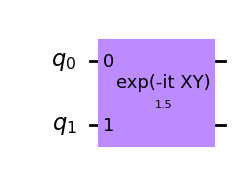

In [30]:
qc = QuantumCircuit(2) # our main circuit
qc.append(peg, [0, 1]) 
# [0, 1] indicates the location of the appending operation. 
# Here, it is qubit-0 to qubit-0 and qubit-1 to qubit-1
# as you can see in the circuit, 0 is connected to 0, 1 is connected to 1
# usually for arbitrary length N, just do qc.append(peg, range(N))
qc.draw(output='mpl')

<div class="alert alert-block alert-success">

**Exercise 3. Building a Function to Construct a Quantum Circuit to Evolve a Pauli Operator**  
    
Build a generic function to construct a quantum circuit for

$$\exp(-i H_{operator} t)$$

using *PauliEvolutionGate* class. 

Note, it must return a quantum circuit object with an input Pauli operator and an input time.
</div>

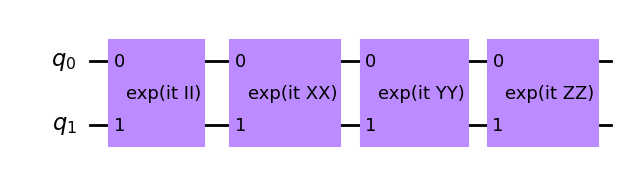

In [31]:
def time_evolve(H_operator, time, synthesis=LieTrotter()):
    num_qubit = H_operator.num_qubits
    ##### ==================================
    # Write your solution in here.    
    peg = PauliEvolutionGate(H_operator, time=time, synthesis=synthesis)
    qc = QuantumCircuit(num_qubit)
    qc.append(peg, range(num_qubit))
    ##### ==================================
    return qc

# Test your circuit
N = 2
H_operator = H_sw_operator(N)
qc_test = time_evolve(H_operator, 1.5)
qc_test.decompose().draw(output='mpl')

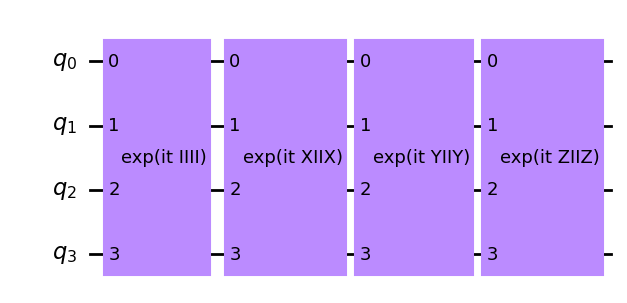

In [32]:
# Test your circuit
N = 4
H_operator = H_sw_operator(N)
qc_test = time_evolve(H_operator, 1.5)
qc_test.decompose().draw(output='mpl')

You should see 4 Pauli exponential blocks here. Why? Because all these Pauli terms are commutative. So, we can simulate them blockwise and without error!

### 0.4. Quantum Circuit Transpilation

You may ask, how do we verify them individually and see the tower structure of CX gates and RZ gates we saw in class?

There are more than one ways to decompose the quantum circuit. To see what we saw in class, we need to transpile the quantum circuits to the basis gates that we are assigning them.

Introducing the *transpile* function, which takes a quantum circuit and a list of basis gates. Run the command below and verify with your expectation.

<div class="alert alert-block alert-success">

**Exercise 4. Transpiling Quantum Circuit to Specified Gate Sets**  
    
Transpile your quantum circuit to basis gates "h", "s", "sdg", "rz", "cx". Does it match your expectation?
</div>

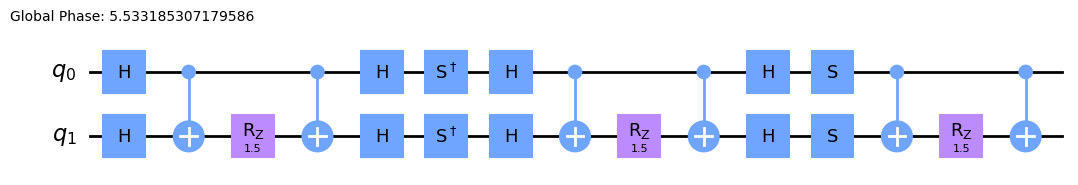

In [42]:
N = 2
H_operator = H_sw_operator(N)
qc_test = time_evolve(H_operator, 1.5).decompose()

transpiled_qc = transpile(qc_test, basis_gates=['h', 's', 'sdg', 'rz', 'cx'], optimization_level=0) # no optimization = 0
transpiled_qc.draw(output='mpl')

Note, you should try to identify **three** towers of Rz gates with CXs. 

The $\exp(-iIIt)=\cos(t) II - i \sin(t) II = \Big(cos(t)-i\sin(t)\Big) II$ becomes part of the global phase, because  so Qiskit automatically skipped its simulation.

### 0.5. Quantum Circuit Initialization and Measurement

Before simulating your quantum circuit, we need to add an initialization block and a measurement block.
    
To make things interesting, try initialize qubit-0 as $|1\rangle$, qubit-1 as $|0\rangle$ state, and then time evolve your two-qubit $H_{sw}$ for $\pi/2$ period, and finally add a measurement block.

Now we have a complete circuit!

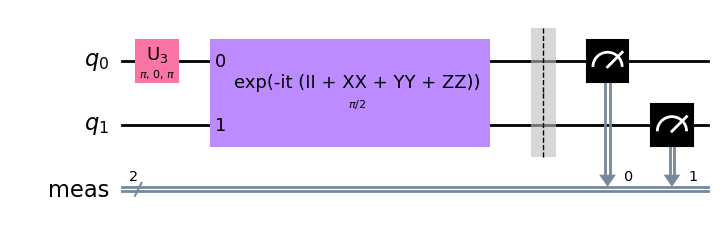

In [43]:
qc_test = QuantumCircuit(2)

# 1. Initialize qubit_0 as |1>, qubit_1 as |0> state, simply apply X gate on qubit 0
qc_test.x(0)

# 2. Time evolve for t = pi/2, using your function *time_evolve* 
H_operator = H_sw_operator(N=2)
qc_test.append(time_evolve(H_operator, np.pi/2), range(2))

# 3. Measure all
qc_test.measure_all()

qc_test.decompose().draw(output='mpl')

To measure the outcome of any quantum circuit, we can use *Sampler* class in Qiskit. 

* With *shots=0*, we mimic an exact simulation using the state vector. 

* With *shots* = a positive integer, we mimic a practical simulation with however many shots on an **ideal** quantum computer. Obviously, the more shots one have, the closer to the exact simulation.

For a realistic simulation on a current **Noisy** quantum computer, one could either introduce a noise model or use IBMQ cloud quantum device (for free!). I will leave this topic to another time given the limited time. [If you are interested, we can discuss later.]

Qiskit has gone through several implementations back and forth, starting with the *execute* function to *Sampler* class. Here, I will simplify write an auxiliary function *sample_with_shots* for our class to use.

In [44]:
def pad_int(k, n):
    return "0"*(n-len(bin(k)[2:]))+bin(k)[2:]
    
def sample_with_shots(circuit, num_qubits, shots=None):
    ''' Using Sampler class, based on Qiskit (v0.44)
        Exact simulation when shots = None
        Shot simulation when shots = integer
    '''
    shot_sampler = Sampler(options={"shots": shots})
    dist = shot_sampler.run(circuit).result().quasi_dists[0]
    dist = {pad_int(k, num_qubits): v for k, v in dist.items()}  # this is added because of Qiskit newly version does not like bitstring anymore
    return dist

It is important to compare exact simulation with shot simulations with our Hamiltonian

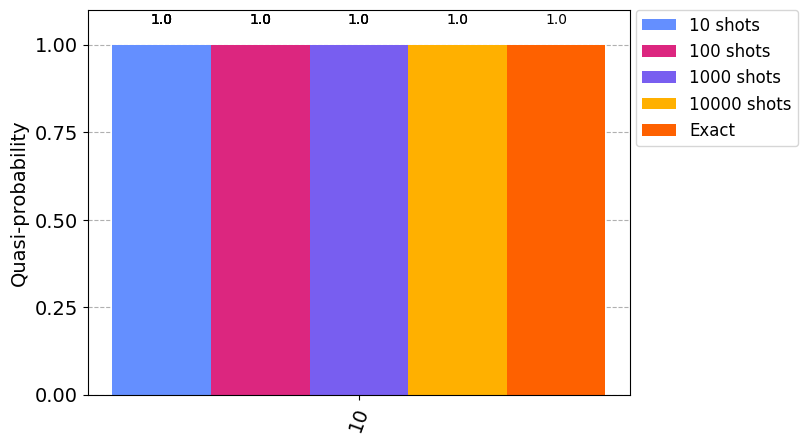

In [45]:
dist_exact  = sample_with_shots(qc_test, 2, None)
dist_10     = sample_with_shots(qc_test, 2, 10)
dist_100    = sample_with_shots(qc_test, 2, 100)
dist_1000   = sample_with_shots(qc_test, 2, 1000)
dist_10000  = sample_with_shots(qc_test, 2, 10000)

dist_list = [dist_10, dist_100, dist_1000, dist_10000, dist_exact]

plot_distribution(dist_list, legend=["10 shots", "100 shots", "1000 shots", "10000 shots", "Exact"])

Since we started with $|q_1q_0\rangle = |01\rangle$ state, you will see the result in **any shot** is now a $|10\rangle = |2\rangle$ state. 

Yes, that is right. You have just implemented a SWAP gate. There are many implementations of SWAP gates. Here, you simulate a SWAP gate by $\exp(-i\frac{(II+XX+YY+ZZ)}{2}\theta)$ with an angle $\theta=\pi/2$, which your simulation time here.

Now, what will happen if you try to rotate only half the angle? What do you think will happen.


<div class="alert alert-block alert-success">

**Exercise 5. Simulate with Ideal Shot-based Simulator**  
    
Now let us try on our own. What if we time evolve the H_sw_operator on $N=4$ qubits for an evolution time to $\pi/4$. 
    
Try to run different number of shots, 10, 100, 1000, 10000, and exact simulation. What do you observe? You may also try it several times.
</div>

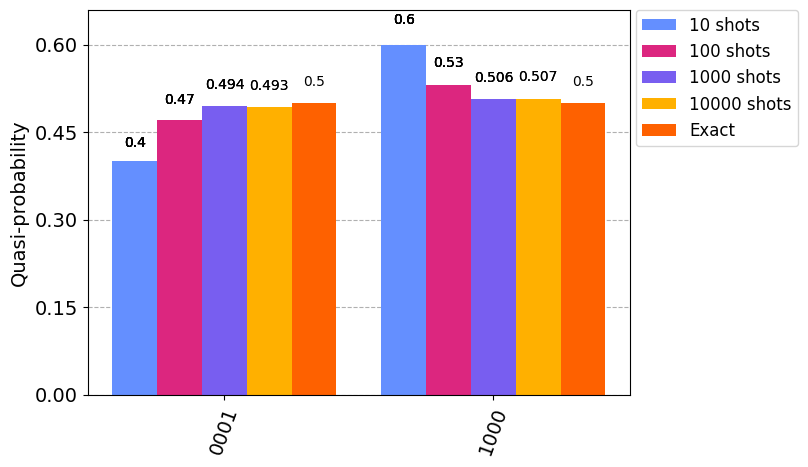

In [46]:
qc_test = QuantumCircuit(4)
##### ==================================
# Write your solution in here.
# 1. Initialize qubit_0 as |1>, qubit_1 as |0> state
qc_test.x(0)

# 2. Time evolve for t = pi/4
N = 4
H_operator = H_sw_operator(N)
qc_test.append(time_evolve(H_operator, np.pi/4), range(N))

# 3. Measure all
qc_test.measure_all()
##### ==================================

dist_exact  = sample_with_shots(qc_test, 4, None)
dist_10     = sample_with_shots(qc_test, 4, 10)
dist_100    = sample_with_shots(qc_test, 4, 100)
dist_1000   = sample_with_shots(qc_test, 4, 1000)
dist_10000  = sample_with_shots(qc_test, 4, 10000)

dist_list = [dist_10, dist_100, dist_1000, dist_10000, dist_exact]

plot_distribution(dist_list, legend=[ "10 shots", "100 shots", "1000 shots", "10000 shots", "Exact",])

It should be an even superposition of $|0001\rangle=|1\rangle$ and $|1000\rangle=|8\rangle$ states right? With the number of shots going larger and larger, the probability distributions should be 0.5 for each.

In practice, this is very important property, with different angles, you can generate desire weighted sum of these one-hot encoded bitstrings, which has many applications especially in quantum machine learning and combinatorial problems.

Now that, we have talked about simulating any Hamiltonian. We will switch to discussing extracting observables from the quantum circuit. 

### 0.6. Quantum Circuit Expectation Value of Observable

More often or not, we are interesting in obtaining the expectation values of certain observable for our evolve state. Those information is useful and can be used to characterize the state of our quantum system, such as the energy.

For example, in our previous simulation, we can also introduce an operator 

$$O=\frac{1}{2}((I-Z)\otimes I\otimes I \otimes I - I\otimes I\otimes I \otimes (I-Z))$$

to describe the asymmetry of the sampled outcome. Remember $\frac{(I-Z)}{2}|0\rangle = 0|0\rangle=0$ and $\frac{(I-Z)}{2}|1\rangle = 1|1\rangle$. Predict what you get if measuring this observable for the exact simulation distribution above?

<div class="alert alert-block alert-success">

**Exercise 6. Building Pauli Observables**  
    
Building Pauli observables is the same as constructing Pauli operators. Let us build
$$O=\frac{1}{2}((I-Z)\otimes I\otimes I \otimes I - I\otimes I\otimes I \otimes (I-Z))$$
</div>

In [47]:
##### ==================================
# Write your solution in here.
O_test = ((I-Z)^I^I^I)/2 - (I^I^I^(I-Z))/2
##### ==================================
O_test

SparsePauliOp(['IIII', 'ZIII', 'IIII', 'IIIZ'],
              coeffs=[ 0.5+0.j, -0.5+0.j, -0.5+0.j,  0.5-0.j])

To run the estimation, there are multiple methods in Qiskit. For convenience, I have written a method for you to estimate your observable using the *Estimator* class.

Play with the simulation with different shots below, and convince yourself everything makes sense.

In [48]:
def estimate_with_shots(circuit, observable, shots=None):
    ''' Using Estimator class, based on Qiskit (v0.44)
        Exact estimation when shots = None
        Shot estimation when shots = integer
    '''    
    _circuit = circuit.copy()
    _circuit.remove_final_measurements()
    shot_estimator = Estimator(options={"shots": shots})
    expectation = shot_estimator.run(_circuit, observable).result().values[0]
    return expectation

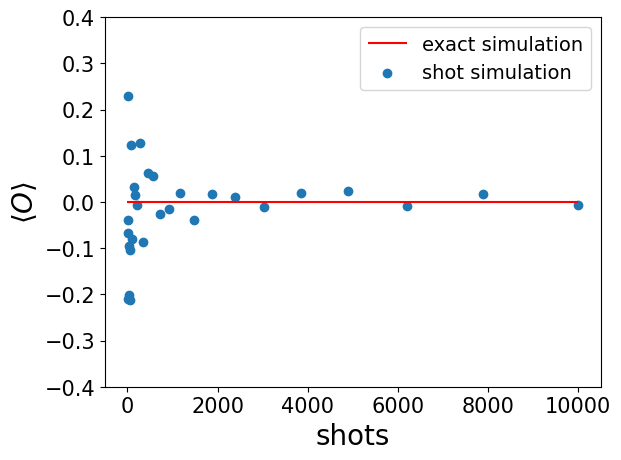

In [49]:
shot_list = np.round(np.geomspace(10, 10000, 30))
expectation_list = []

for shots in shot_list:
    expectation = estimate_with_shots(qc_test, O_test, shots)
    expectation_list.append(expectation)
    
exact_est = estimate_with_shots(qc_test, O_test, None)
plt.hlines(exact_est, 0, 10000, ls='solid', color='red', label='exact simulation')
plt.scatter(shot_list, expectation_list, label='shot simulation')
plt.ylabel(r'$\langle O\rangle$', fontsize=20)
plt.xlabel('shots', fontsize=20)
plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.ylim(-0.4, 0.4)
plt.legend(fontsize=14)
plt.show()

You should observe that the expectation value approaches 0 as the number of shots increase. It is because, our observable is basically a number operator (or counting operator if you like). 

It counts the number of 1's in highest and the lowest qubit and calculate their difference. From the distribution earlier, you should expect zero, since we have an even distribution of $|0001\rangle$ and $|1000\rangle$.

You should also see that having enough shots is crucial to simulation results. On the other hand, having too many shots will not help the simulation after certain point. It is essentially closely related the state space of the many-qubit systems. In quantum information science, the theoretical number of shots $\sim 1/\mathcal{O}(\epsilon^2)$ where $\epsilon$ is the accuracy.

## Part 1. Ising Model

In this part, you will simulate the 1-dimensional Ising model Hamiltonian in real time using quantum circuit. 

### 1.1. The Ising Hamiltonian and Observables

The Ising model is one of the simplest yet very powerful model in statistical mechanics. It can be used to explain many property of matter such as phase transitions. Here, we want to use quantum simulation to study the property of the Ising model in one dimension. To make things more interesting, we will look at the Ising model in an arbitrary background field.

<div>
    <img src="ising_model.png" width=600>
</div>

In one dimension, the spins in the Ising model is placed along the horizontal X direction. Their spins are pointing in the direction of either $Z$ and $-Z$ direction. The Hamiltonian can be written as follows

$$
H = -J \sum_{i=0}^{L-1} \sigma_i \sigma_{i+1} - h \sum_{i=0}^{L-1} \sigma_i\cdot \hat{n}
$$

where the $J$ is the spin coupling strength and $h$ is magnetic field strength. The unit vector $\hat{n}$ points in an arbitrary direction in the X-Z plane. For simplicity, we use uniform strength for all spins. The spins $\sigma_i$ takes values of +1 and -1, and they satisfy the periodic boundary condition, $\sigma_L = \sigma_0$.

On the quantum circuit, one can represent the spin up (down) with the quantum state $|0\rangle$ ($|1\rangle$). Then, the Ising Hamiltonian can be naturally mapped to Pauli bases by using the mapping of $\sigma_i \mapsto Z_i$. The "qubitized" Ising Hamiltonian becomes,

$$
H = -J \sum_{i=0}^{L-1} Z_i Z_{i+1} - h \sum_{i=0}^{L-1} \big(\sin(\alpha)Z_i+\cos(\alpha)X_i\big)
$$

where angle $\alpha$ is used to parameterize the field. $\alpha=0$ indicates a purely transverse field. $\alpha=\pi/2$ gives a purely vertical field.

<div class="alert alert-block alert-success">

**Exercise 7. Building Ising Hamiltonian with an External Field**  

Let us first write a function to generate the Ising Hamiltonian with an arbitrary external field. The function you write should work for any lattice of $L$ spins with their spin coupling $J$ and an external field with its strength $h$ and angle $\alpha$.

Tip: since the Ising Hamiltonian is generic, you may want to look at Exercise 2 and use For-loops to generate it. To make it simple, we already wrote part of the code in the function.
</div>

In [6]:
def H_Ising_operator(L, J, h, alpha=0):

    # List of Hamiltonian terms as 3-tuples containing
    # (1) the Pauli string,
    # (2) the qubit indices corresponding to the Pauli string,
    # (3) the coefficient.
    ##### ==================================
    # Write your solution in here.
    ZZ_tuples = [("ZZ", [i, (i + 1) % L], -J) for i in range(0, L)]
    Z_tuples = [("Z", [i], -h * np.sin(alpha)) for i in range(0, L)]
    X_tuples = [("X", [i], -h * np.cos(alpha)) for i in range(0, L)]
    ##### ==================================
    
    # We create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *Z_tuples, *X_tuples], num_qubits=L)
    return hamiltonian.simplify()

Test to see if your Hamiltonian make sense at different angles

In [9]:
L = 4
J = 0.2
h = 1.2
alpha = 0

H_operator = H_Ising_operator(L=L, J=J, h=h, alpha=alpha)
H_operator

SparsePauliOp(['IIZZ', 'IZZI', 'ZZII', 'ZIIZ', 'IIIX', 'IIXI', 'IXII', 'XIII'],
              coeffs=[-0.2+0.j, -0.2+0.j, -0.2+0.j, -0.2+0.j, -1.2+0.j, -1.2+0.j, -1.2+0.j,
 -1.2+0.j])

In [10]:
L = 4
J = 0.2
h = 1.2
alpha = np.pi/2

H_operator = H_Ising_operator(L=L, J=J, h=h, alpha=alpha)
H_operator

SparsePauliOp(['IIZZ', 'IZZI', 'ZZII', 'ZIIZ', 'IIIZ', 'IIZI', 'IZII', 'ZIII'],
              coeffs=[-0.2+0.j, -0.2+0.j, -0.2+0.j, -0.2+0.j, -1.2+0.j, -1.2+0.j, -1.2+0.j,
 -1.2+0.j])

In [11]:
L = 4
J = 0.2
h = 1.2
alpha = np.pi/4

H_operator = H_Ising_operator(L=L, J=J, h=h, alpha=alpha)
H_operator

SparsePauliOp(['IIZZ', 'IZZI', 'ZZII', 'ZIIZ', 'IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIIX', 'IIXI', 'IXII', 'XIII'],
              coeffs=[-0.2       +0.j, -0.2       +0.j, -0.2       +0.j, -0.2       +0.j,
 -0.84852814+0.j, -0.84852814+0.j, -0.84852814+0.j, -0.84852814+0.j,
 -0.84852814+0.j, -0.84852814+0.j, -0.84852814+0.j, -0.84852814+0.j])

Now that your Hamiltonian is working. Let us look at how to several useful observables for studying the Ising model.

The magnetization operator $M$ is a sum of all the spins in the system, characterizing the total magnetization,
$$M = \sum_{i}^{L-1} \sigma_i.$$
The correlation operator $C$ is a sum of all neighboring spin correlations,
$$C = \frac{1}{L}\sum_{i}^{L-1} \sigma_i\sigma_{i+1}.$$
Note these are global observables. 

<div class="alert alert-block alert-success">

**Exercise 8. Building Magnetization and Correlation Operator**  

Let us build these global operators $M$ and $C$ that will be used for the simulation. Mapping to Pauli matrices is straightforward and we leave it for you to decide.
</div>

In [12]:
def magnetization_op(L):
    ##### ==================================
    # Write your solution in here.
    magnetization_op = SparsePauliOp.from_sparse_list([("Z", [i], 1.0) for i in range(0, L)], num_qubits=L)
    ##### ==================================
    return magnetization_op

def correlation_op(L):
    ##### ==================================
    # Write your solution in here.
    correlation_op = SparsePauliOp.from_sparse_list([("ZZ", [i, (i + 1) % L], 1.0) for i in range(0, L)], num_qubits=L) / L
    ##### ==================================
    return correlation_op

In [13]:
L = 6
print(magnetization_op(L))
print(correlation_op(L))

SparsePauliOp(['IIIIIZ', 'IIIIZI', 'IIIZII', 'IIZIII', 'IZIIII', 'ZIIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])
SparsePauliOp(['IIIIZZ', 'IIIZZI', 'IIZZII', 'IZZIII', 'ZZIIII', 'ZIIIIZ'],
              coeffs=[0.16666667+0.j, 0.16666667+0.j, 0.16666667+0.j, 0.16666667+0.j,
 0.16666667+0.j, 0.16666667+0.j])


### 1.2. Quantum Circuit Time Evolution (full steps)

Now, we have all the ingrediences for the Ising model except for the evolution part. Notice that previously we wrote a *time_evolve* function that evolves a given Hamiltonian $H$ for time duration $t$ based on some trotterization strategy. From the Trotter Formula, we know that in general this will indice an error ~ $\mathcal{O}(t^2)$ if $H$ contains non-commutating parts. When $t$ is small, this is okay. However, in quantum information science, we are typically interested in the long time simulation in a real-time evolution. 

Therefore, naturally, to reduce the error, we would want to divide the full time evolution $t$ into many tiny steps $\Delta t$, and use trotterization scheme within each time slice. Namely, with $N_s = t / \Delta t$ representing the total number of steps, we write
$$ e^{iHt} = \prod_{i=0}^{N_s}e^{iH\Delta t} = \underbrace{e^{iH\Delta t}e^{iH\Delta t}... e^{iH\Delta t}}_{N_s \text{ many time steps}}. $$
In each little $e^{iH\Delta t}$ evolution, we apply the trotter formula on the internal parts of the $H$.

The typical trotter formulas are:
* Lie trotter formula (1st order): $e^{i(A+B)\Delta t} = e^{iA\Delta t}e^{iB\Delta t} + \mathcal{O}((\Delta t)^2)$   
* Suzuki trotter formula (2nd order): $e^{i(A+B)\Delta t} = e^{iB/2\Delta t}e^{iA\Delta t}e^{iB/2\Delta t} + \mathcal{O}((\Delta t)^3)$   
* ...

We can see that higher order trotterization will reduce the total evolution error. Lie trotterization on each step will give a total trotterization error up to $\mathcal{O}((\Delta t)^2)$ and Suzuki trotterization with higher order $p$ gives an error up to $\mathcal{O}((\Delta t)^{p+1})$.

Nonetheless, higher order trotterizations will introduce many more quantum gates than lower order ones. Having smaller step size will probably be fine with first order trotterization. In principle, there is a trade off between step size $\Delta t$ and trotterization order $p$.

Your first task to expand the previously written *time_evolve* function for an arbitrary time period and an arbitrary number of total steps.

<div class="alert alert-block alert-success">

**Exercise 9. Writing a Function to Create a Time Evolution Circuit with Many Trotterization Steps** 

Your function should takes in an Hamiltonian operator, *H_operator*, and an initial quantum circuit, *initial_circuit*. It will return a quantum circuit that evolves the Hamiltonian for a total number of steps, *total_steps*, where each step size is *dt*.

Trotterization strategy should also be passed in as an argument using the *synthesis* variable. By default, we use first-order Lie Trotter formula.
</div>

In [14]:
def time_evolve_many_steps(H_operator, dt, total_steps, initial_circuit, synthesis=LieTrotter()):
    N = H_operator.num_qubits
    qc = initial_circuit.copy()
    ##### ==================================
    # Write your solution in here.
    for i in range(total_steps):
        qc.append(time_evolve(H_operator, dt, synthesis=synthesis), range(N))
    ##### ==================================
    qc.measure_all()
    return qc

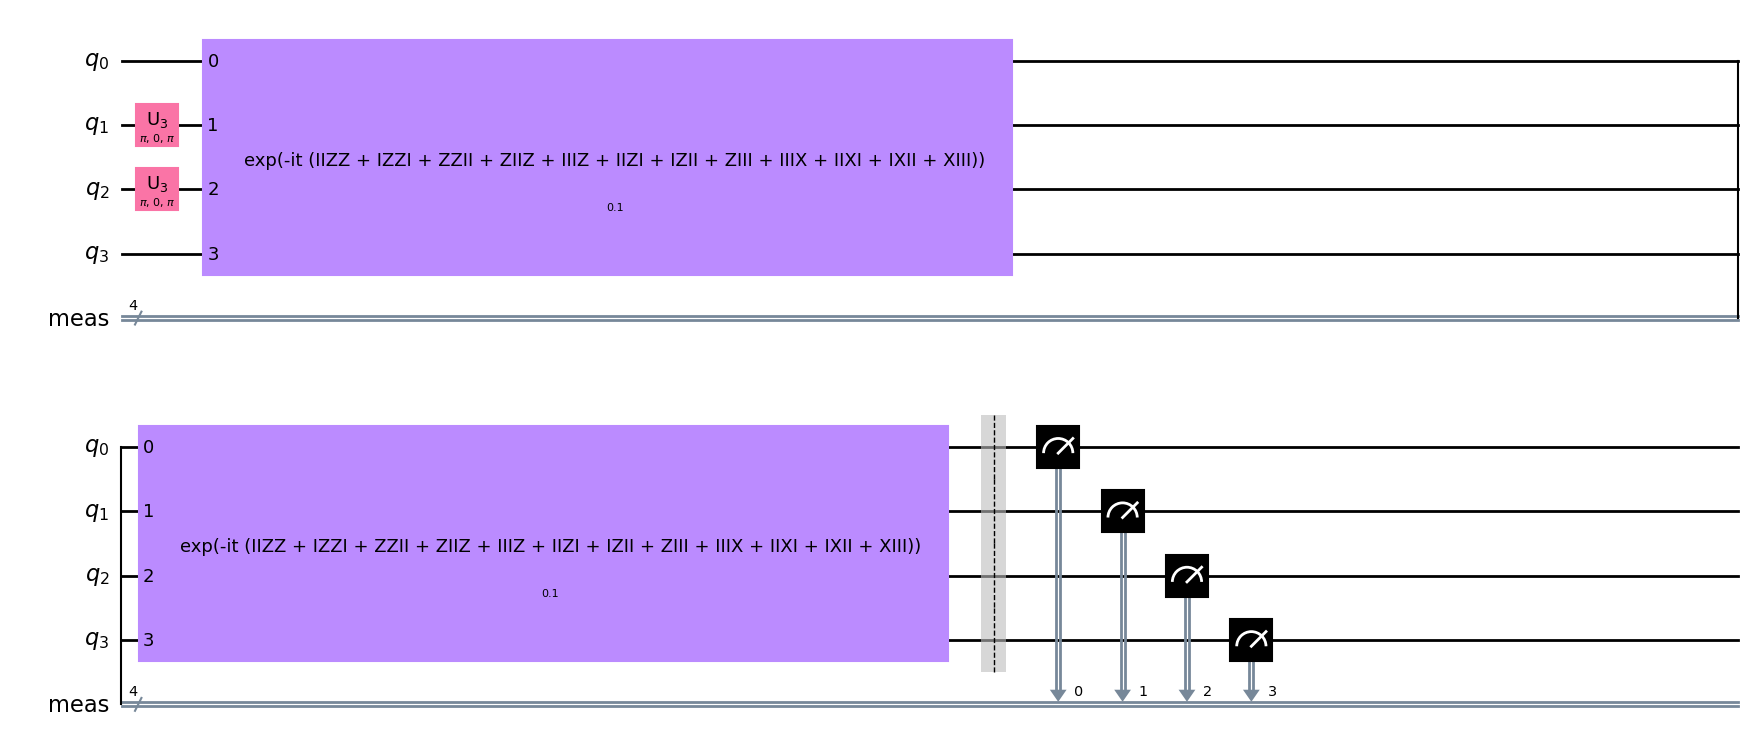

In [39]:
# test to see if it is working
L = 4
J = 0.2
h = 1.2
alpha = np.pi/4

H_operator = H_Ising_operator(L=L, J=J, h=h, alpha=alpha)
initial_circuit = QuantumCircuit(L)
initial_circuit.x(1)
initial_circuit.x(2)

dt = 0.1
total_steps = 2
synthesis = LieTrotter()

qc = time_evolve_many_steps(H_operator, dt, total_steps, initial_circuit, synthesis)
qc.decompose().draw(output="mpl")

### 1.3. Real Time Evolution of the Ising Model - Global Observable

<div class="alert alert-block alert-success">

**Exercise 10. Real-time Evolution of the Ising Model**  

Now, let us evolve the Ising Hamiltonian in real time. You can use our following code block. Here, we evolve the system and measure the energy, total magnetization, and total correlation, to $t=12$ seconds.

Specifically, we start with $L = 6$, and a coupling $J =0.2 \ll h =1.2$ and $\alpha=0$. What does it mean? Does your result agree with your expectation?

What if we use a smaller time step?

You can also play with the parameters to see different effects on the system.
</div>

In [99]:
###### Ising Model Setup ######
L = 6
J = 0.2
h = 1.2
alpha = 0

H_operator = H_Ising_operator(L=L, J=J, h=h, alpha=alpha)
magnet_op = magnetization_op(L)
corr_op = correlation_op(L)

initial_spin_downs = [0, L-1]    # spin downs
init_qc = QuantumCircuit(L)
init_qc.x(initial_spin_downs)    # create initial spin downs at specified locations

###### Real-time Evolution Setup ######
dt = 0.5
total_steps = 24   # t/dt = 12/0.5 = 24
total_time = total_steps*dt
shots = None
synthesis = LieTrotter()

###### Quantum Simulation ######
lie_exp_vals = []; ts_vals = []
t0 = current_time()
for steps in range(0, total_steps+1):
    time = steps*dt
    qc = time_evolve_many_steps(H_operator, dt, steps, initial_circuit=init_qc, synthesis=synthesis)
    E_val = estimate_with_shots(qc, H_operator, shots)
    M_val = estimate_with_shots(qc, magnet_op, shots)
    C_val = estimate_with_shots(qc, corr_op, shots)
    print(f'steps = {steps:>4} | time = {time:>5.2f}s | E = {E_val:>5.2f} | M = {M_val:>5.2f} | C = {C_val:>5.2f}')
    lie_exp_vals.append([E_val, M_val, C_val])
    ts_vals.append(time)
print(f"time elapsed {current_time()-t0:.2f}s")

steps =    0 | time =  0.00s | E = -0.40 | M =  2.00 | C =  0.33
steps =    1 | time =  0.50s | E = -0.05 | M =  0.72 | C =  0.04
steps =    2 | time =  1.00s | E = -0.53 | M = -1.40 | C =  0.18
steps =    3 | time =  1.50s | E = -0.18 | M = -1.65 | C =  0.25
steps =    4 | time =  2.00s | E = -0.25 | M =  0.10 | C =  0.05
steps =    5 | time =  2.50s | E = -0.42 | M =  1.46 | C =  0.25
steps =    6 | time =  3.00s | E = -0.16 | M =  0.87 | C =  0.15
steps =    7 | time =  3.50s | E = -0.35 | M = -0.55 | C =  0.14
steps =    8 | time =  4.00s | E = -0.29 | M = -0.98 | C =  0.19
steps =    9 | time =  4.50s | E = -0.28 | M = -0.21 | C =  0.16
steps =   10 | time =  5.00s | E = -0.29 | M =  0.48 | C =  0.16
steps =   11 | time =  5.50s | E = -0.30 | M =  0.39 | C =  0.16
steps =   12 | time =  6.00s | E = -0.29 | M = -0.03 | C =  0.18
steps =   13 | time =  6.50s | E = -0.27 | M = -0.18 | C =  0.14
steps =   14 | time =  7.00s | E = -0.32 | M = -0.07 | C =  0.18
steps =   15 | time =  7.

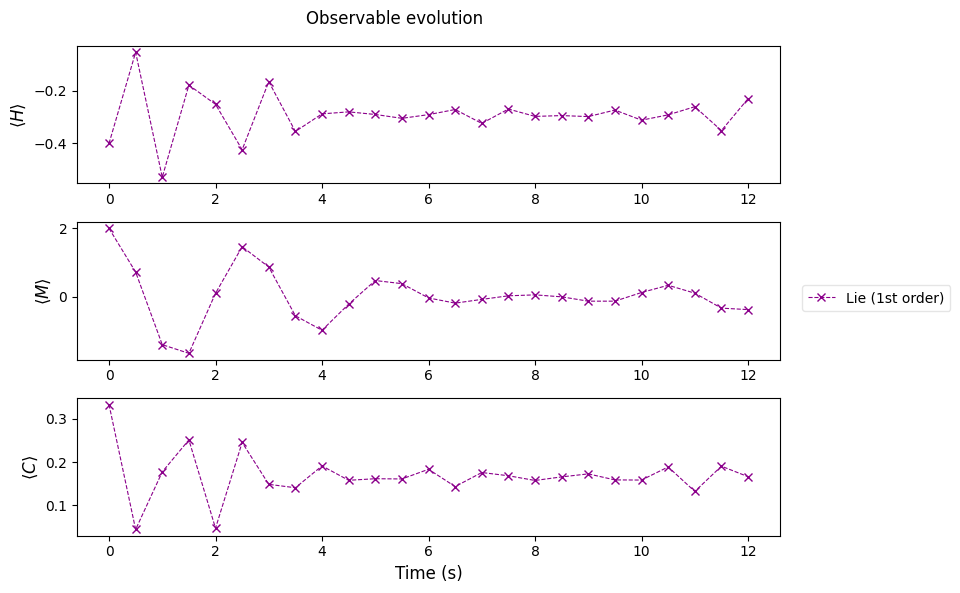

In [89]:
fig, axes = plt.subplots(3, figsize=(8, 6)); fs = 12
# simulation
lie_exp_vals = np.array(lie_exp_vals)
axes[0].plot(ts_vals, lie_exp_vals[:,0], label="Lie (1st order)", marker="x", c="darkmagenta", ls="dashed", lw=0.8)
axes[1].plot(ts_vals, lie_exp_vals[:,1], label="Lie (1st order)", marker="x", c="darkmagenta", ls="dashed", lw=0.8)
axes[2].plot(ts_vals, lie_exp_vals[:,2], label="Lie (1st order)", marker="x", c="darkmagenta", ls="dashed", lw=0.8)
axes[0].set_ylabel(r"$\langle H \rangle$", fontsize=fs)
axes[1].set_ylabel(r"$\langle M \rangle$", fontsize=fs)
axes[2].set_ylabel(r"$\langle C \rangle$", fontsize=fs)
axes[2].set_xlabel("Time (s)", fontsize=fs)
fig.suptitle("Observable evolution")
legend = fig.legend(*axes[0].get_legend_handles_labels(), bbox_to_anchor=(1.0, 0.5), loc="center left", framealpha=0.5,)
fig.tight_layout()
plt.show()

### 1.4. Classical Time Evolution using Matrix Exponential

To verify whether our "quantum" simulation is correct or not, we directly perform exact matrix exponential on an initial statevector. Here we use *scipy.linalg.expm* to evaluate the time evolution operator $e^{iH\Delta t}$ approximately at each step. Such approximation is very good for low number of qubits ~ 10 qubits, so they are basically exact. For higher number of qubits, one would need to obtain the eigenvalue and eigenvectors of the Hamiltonian that can be very costy very quickly (Not a subject in our lab section today).

Here, we simply gave the code below for you to test. It may take sometime to simulate ~ 40 seconds. In particular, we used double the amount of total steps to make the curve smooth.

Does your exact result agree with first order simulation?

In [90]:
###### Ising Model Setup ######
L = 6
J = 0.2
h = 1.2
alpha = 0

H_operator = H_Ising_operator(L=L, J=J, h=h, alpha=alpha)
magnet_op = magnetization_op(L)
corr_op = correlation_op(L)

H_matrix = H_operator.to_matrix()
sv_init = Statevector.from_label("100001")

###### Real-time Evolution Setup ######
dt = 0.5
total_steps = 24   # t/dt = 12/0.5 = 24
total_time = total_steps*dt
exact_ts_val = np.linspace(0, total_time, total_steps*2)

###### Exact Classical Simulation ######
t0 = current_time()
exact_evolution = [sv_init.evolve(LA.expm(-1j * time * H_matrix)) for time in exact_ts_val]
print(f"time elapsed {current_time()-t0:.2f}s")

exact_energy = np.real([sv.expectation_value(H_operator) for sv in exact_evolution])
exact_magnetization = np.real([sv.expectation_value(magnet_op) for sv in exact_evolution])
exact_correlation = np.real([sv.expectation_value(corr_op) for sv in exact_evolution])

time elapsed 21.34s


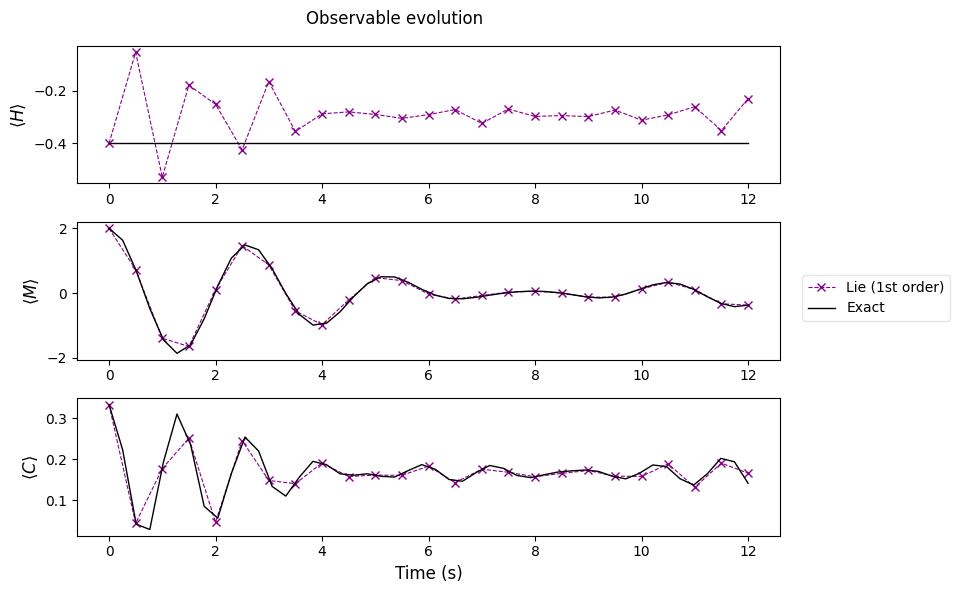

In [91]:
fig, axes = plt.subplots(3, figsize=(8, 6)); fs = 12
# simulation
lie_exp_vals = np.array(lie_exp_vals)
axes[0].plot(ts_vals, lie_exp_vals[:,0], label="Lie (1st order)", marker="x", c="darkmagenta", ls="dashed", lw=0.8)
axes[1].plot(ts_vals, lie_exp_vals[:,1], label="Lie (1st order)", marker="x", c="darkmagenta", ls="dashed", lw=0.8)
axes[2].plot(ts_vals, lie_exp_vals[:,2], label="Lie (1st order)", marker="x", c="darkmagenta", ls="dashed", lw=0.8)
# exact
axes[0].plot(exact_ts_val, exact_energy, label="Exact", c="k", ls="-", lw=1)
axes[1].plot(exact_ts_val, exact_magnetization, label="Exact", c="k", ls="-", lw=1)
axes[2].plot(exact_ts_val, exact_correlation, label="Exact", c="k", ls="-", lw=1)
axes[0].set_ylabel(r"$\langle H \rangle$", fontsize=fs)
axes[1].set_ylabel(r"$\langle M \rangle$", fontsize=fs)
axes[2].set_ylabel(r"$\langle C \rangle$", fontsize=fs)
axes[2].set_xlabel("Time (s)", fontsize=fs)
fig.suptitle("Observable evolution")
legend = fig.legend(*axes[0].get_legend_handles_labels(), bbox_to_anchor=(1.0, 0.5), loc="center left", framealpha=0.5,)
fig.tight_layout()
plt.show()

<div class="alert alert-block alert-success">

**Exercise 11. Real-time Evolution of the Ising Model, part 2**  

Does your real time simulation agree with the exact simulation? What is going on if they are in agreement? How should you fix them? 

Let us see if you can produce a real time simulation that matches the exact solution up to 20 seconds.

Hint: trotterization step, or higher order trotter formula may be helpful?
</div>

In [92]:
### ONE SOLUTION. with higher trotter formula ###
###### Ising Model Setup ######
L = 6
J = 0.2
h = 1.2
alpha = 0

H_operator = H_Ising_operator(L=L, J=J, h=h, alpha=alpha)
magnet_op = magnetization_op(L)
corr_op = correlation_op(L)

initial_spin_downs = [0, L-1]    # spin downs
init_qc = QuantumCircuit(L)
init_qc.x(initial_spin_downs)    # create initial spin downs at specified locations

###### Real-time Evolution Setup ######
dt = 0.5
total_steps = 24   # t/dt = 12/0.5 = 24
total_time = total_steps*dt
shots = None
synthesis = SuzukiTrotter(order=4)

###### Quantum Simulation ######
suzuki_exp_vals = []; ts_vals = []
t0 = current_time()
for steps in range(0, total_steps+1):
    time = steps*dt
    qc = time_evolve_many_steps(H_operator, dt, steps, initial_circuit=init_qc, synthesis=synthesis)
    E_val = estimate_with_shots(qc, H_operator, shots)
    M_val = estimate_with_shots(qc, magnet_op, shots)
    C_val = estimate_with_shots(qc, corr_op, shots)
    print(f'steps = {steps:>4} | time = {time:>5.2f}s | E = {E_val:>5.2f} | M = {M_val:>5.2f} | C = {C_val:>5.2f}')
    suzuki_exp_vals.append([E_val, M_val, C_val])
    ts_vals.append(time)
print(f"time elapsed {current_time()-t0:.2f}s")

steps =    0 | time =  0.00s | E = -0.40 | M =  2.00 | C =  0.33
steps =    1 | time =  0.50s | E = -0.41 | M =  0.74 | C =  0.05
steps =    2 | time =  1.00s | E = -0.40 | M = -1.38 | C =  0.18
steps =    3 | time =  1.50s | E = -0.40 | M = -1.67 | C =  0.25
steps =    4 | time =  2.00s | E = -0.41 | M =  0.05 | C =  0.05
steps =    5 | time =  2.50s | E = -0.40 | M =  1.45 | C =  0.24
steps =    6 | time =  3.00s | E = -0.40 | M =  0.93 | C =  0.15
steps =    7 | time =  3.50s | E = -0.40 | M = -0.49 | C =  0.14
steps =    8 | time =  4.00s | E = -0.40 | M = -0.99 | C =  0.19
steps =    9 | time =  4.50s | E = -0.40 | M = -0.29 | C =  0.16
steps =   10 | time =  5.00s | E = -0.40 | M =  0.44 | C =  0.16
steps =   11 | time =  5.50s | E = -0.40 | M =  0.43 | C =  0.16
steps =   12 | time =  6.00s | E = -0.40 | M =  0.02 | C =  0.18
steps =   13 | time =  6.50s | E = -0.40 | M = -0.18 | C =  0.15
steps =   14 | time =  7.00s | E = -0.40 | M = -0.10 | C =  0.18
steps =   15 | time =  7.

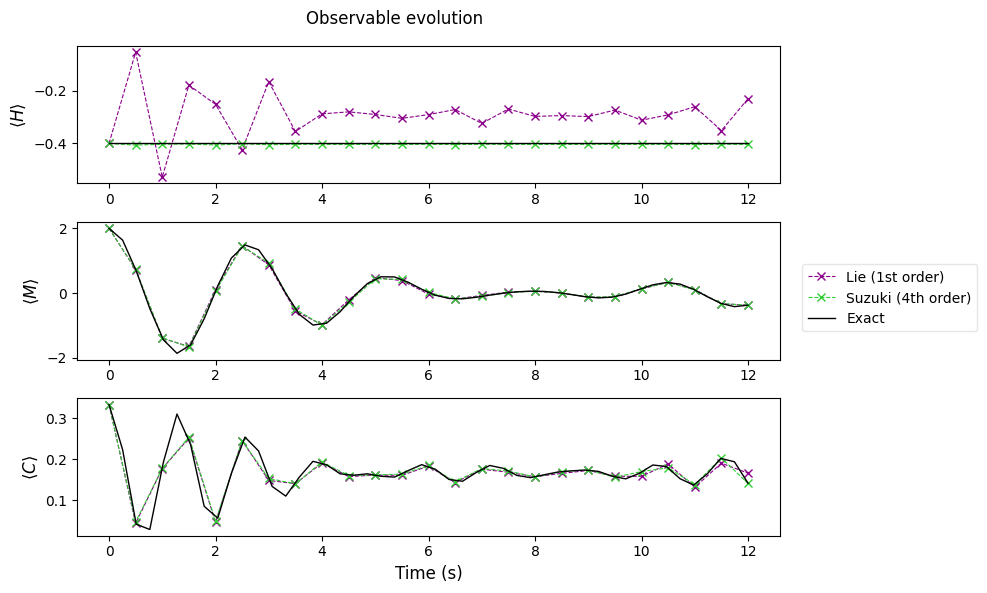

In [93]:
fig, axes = plt.subplots(3, figsize=(8, 6)); fs = 12
# simulation 1st order
lie_exp_vals = np.array(lie_exp_vals)
axes[0].plot(ts_vals, lie_exp_vals[:,0], label="Lie (1st order)", marker="x", c="darkmagenta", ls="dashed", lw=0.8)
axes[1].plot(ts_vals, lie_exp_vals[:,1], label="Lie (1st order)", marker="x", c="darkmagenta", ls="dashed", lw=0.8)
axes[2].plot(ts_vals, lie_exp_vals[:,2], label="Lie (1st order)", marker="x", c="darkmagenta", ls="dashed", lw=0.8)
# simulation 4th order
suzuki_exp_vals = np.array(suzuki_exp_vals)
axes[0].plot(ts_vals, suzuki_exp_vals[:,0], label="Suzuki (4th order)", marker="x", c="limegreen", ls="dashed", lw=0.8)
axes[1].plot(ts_vals, suzuki_exp_vals[:,1], label="Suzuki (4th order)", marker="x", c="limegreen", ls="dashed", lw=0.8)
axes[2].plot(ts_vals, suzuki_exp_vals[:,2], label="Suzuki (4th order)", marker="x", c="limegreen", ls="dashed", lw=0.8)
# exact
axes[0].plot(exact_ts_val, exact_energy, label="Exact", c="k", ls="-", lw=1)
axes[1].plot(exact_ts_val, exact_magnetization, label="Exact", c="k", ls="-", lw=1)
axes[2].plot(exact_ts_val, exact_correlation, label="Exact", c="k", ls="-", lw=1)
axes[0].set_ylabel(r"$\langle H \rangle$", fontsize=fs)
axes[1].set_ylabel(r"$\langle M \rangle$", fontsize=fs)
axes[2].set_ylabel(r"$\langle C \rangle$", fontsize=fs)
axes[2].set_xlabel("Time (s)", fontsize=fs)
fig.suptitle("Observable evolution")
legend = fig.legend(*axes[0].get_legend_handles_labels(), bbox_to_anchor=(1.0, 0.5), loc="center left", framealpha=0.5,)
fig.tight_layout()
plt.show()

In [102]:
### ANOTHER SOLUTION. with smaller time steps ###
###### Ising Model Setup ######
L = 6
J = 0.2
h = 1.2
alpha = 0

H_operator = H_Ising_operator(L=L, J=J, h=h, alpha=alpha)
magnet_op = magnetization_op(L)
corr_op = correlation_op(L)

initial_spin_downs = [0, L-1]    # spin downs
init_qc = QuantumCircuit(L)
init_qc.x(initial_spin_downs)    # create initial spin downs at specified locations

###### Real-time Evolution Setup ######
dt = 0.2
total_steps = int(12/dt)   # t/dt = 12/0.5 = 24
total_time = total_steps*dt
shots = None
synthesis = LieTrotter()

###### Quantum Simulation ######
smaller_lie_exp_vals = []; small_ts_vals = []
t0 = current_time()
for steps in range(0, total_steps+1):
    time = steps*dt
    qc = time_evolve_many_steps(H_operator, dt, steps, initial_circuit=init_qc, synthesis=synthesis)
    E_val = estimate_with_shots(qc, H_operator, shots)
    M_val = estimate_with_shots(qc, magnet_op, shots)
    C_val = estimate_with_shots(qc, corr_op, shots)
    print(f'steps = {steps:>4} | time = {time:>5.2f}s | E = {E_val:>5.2f} | M = {M_val:>5.2f} | C = {C_val:>5.2f}')
    smaller_lie_exp_vals.append([E_val, M_val, C_val])
    small_ts_vals.append(time)
print(f"time elapsed {current_time()-t0:.2f}s")

steps =    0 | time =  0.00s | E = -0.40 | M =  2.00 | C =  0.33
steps =    1 | time =  0.20s | E = -0.31 | M =  1.77 | C =  0.26
steps =    2 | time =  0.40s | E = -0.29 | M =  1.15 | C =  0.11
steps =    3 | time =  0.60s | E = -0.35 | M =  0.28 | C =  0.01
steps =    4 | time =  0.80s | E = -0.43 | M = -0.63 | C =  0.04
steps =    5 | time =  1.00s | E = -0.47 | M = -1.38 | C =  0.18
steps =    6 | time =  1.20s | E = -0.44 | M = -1.81 | C =  0.29
steps =    7 | time =  1.40s | E = -0.36 | M = -1.82 | C =  0.30
steps =    8 | time =  1.60s | E = -0.31 | M = -1.42 | C =  0.19
steps =    9 | time =  1.80s | E = -0.32 | M = -0.74 | C =  0.08
steps =   10 | time =  2.00s | E = -0.39 | M =  0.06 | C =  0.05
steps =   11 | time =  2.20s | E = -0.44 | M =  0.80 | C =  0.12
steps =   12 | time =  2.40s | E = -0.44 | M =  1.31 | C =  0.21
steps =   13 | time =  2.60s | E = -0.39 | M =  1.50 | C =  0.26
steps =   14 | time =  2.80s | E = -0.35 | M =  1.35 | C =  0.22
steps =   15 | time =  3.

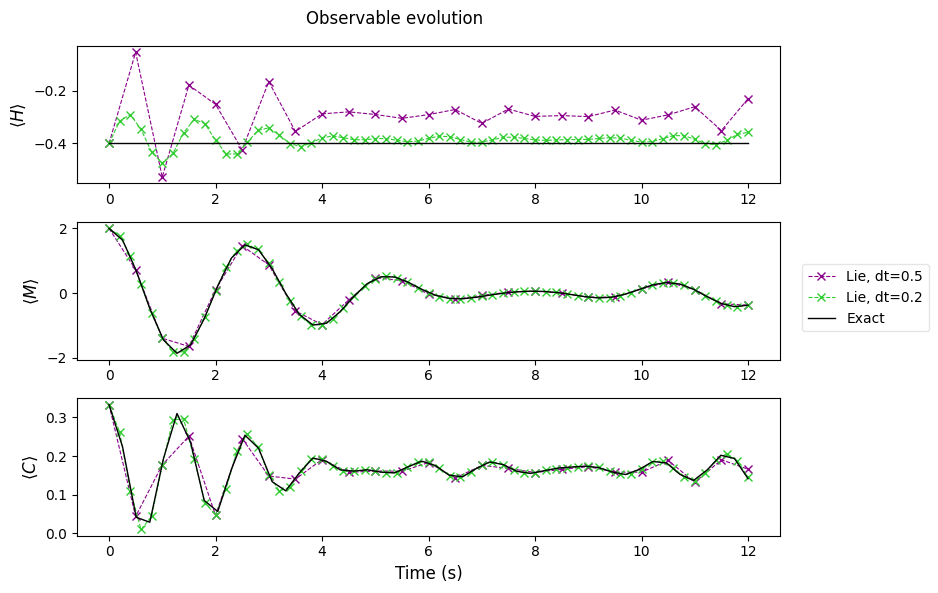

In [104]:
fig, axes = plt.subplots(3, figsize=(8, 6)); fs = 12
# simulation 1st order, large step size
lie_exp_vals = np.array(lie_exp_vals)
axes[0].plot(ts_vals, lie_exp_vals[:,0], label="Lie, dt=0.5", marker="x", c="darkmagenta", ls="dashed", lw=0.8)
axes[1].plot(ts_vals, lie_exp_vals[:,1], marker="x", c="darkmagenta", ls="dashed", lw=0.8)
axes[2].plot(ts_vals, lie_exp_vals[:,2], marker="x", c="darkmagenta", ls="dashed", lw=0.8)
# simulation 1st order, small step size
smaller_lie_exp_vals = np.array(smaller_lie_exp_vals)
axes[0].plot(small_ts_vals, smaller_lie_exp_vals[:,0], label="Lie, dt=0.2", marker="x", c="limegreen", ls="dashed", lw=0.8)
axes[1].plot(small_ts_vals, smaller_lie_exp_vals[:,1], marker="x", c="limegreen", ls="dashed", lw=0.8)
axes[2].plot(small_ts_vals, smaller_lie_exp_vals[:,2], marker="x", c="limegreen", ls="dashed", lw=0.8)
# exact
axes[0].plot(exact_ts_val, exact_energy, label="Exact", c="k", ls="-", lw=1)
axes[1].plot(exact_ts_val, exact_magnetization, label="Exact", c="k", ls="-", lw=1)
axes[2].plot(exact_ts_val, exact_correlation, label="Exact", c="k", ls="-", lw=1)
axes[0].set_ylabel(r"$\langle H \rangle$", fontsize=fs)
axes[1].set_ylabel(r"$\langle M \rangle$", fontsize=fs)
axes[2].set_ylabel(r"$\langle C \rangle$", fontsize=fs)
axes[2].set_xlabel("Time (s)", fontsize=fs)
fig.suptitle("Observable evolution")
legend = fig.legend(*axes[0].get_legend_handles_labels(), bbox_to_anchor=(1.0, 0.5), loc="center left", framealpha=0.5,)
fig.tight_layout()
plt.show()

### 1.5. Real Time Evolution of the Ising Model - Local Observable

It may also be fun to visualize the magnetization at each site in the lattice and observe how they evolve over time. These local magnetization operator at each spin site $i$ is basically $M_i = \sigma_i$. With exact simulation result, we can see the magnetization damps as time evolves.

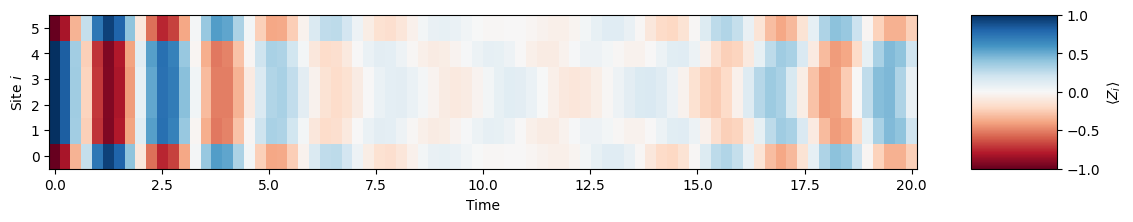

In [75]:
from matplotlib import cm

# An inner list comprehension loops over the terms of the SparsePauliOp magnetization_op, which corresponds to the magnetization of each one of the sites
local_magnet = np.real([[sv.expectation_value(term) for term in magnet_op] for sv in exact_evolution])

# The shape of magnetizations is (101, 6), containing <Z>(t) for each site 0, 1, ..., 5
plt.figure(figsize=(14, 2))

# Create the 2-dim xx and yy arrays tiling the grid with the x and y values
xx, yy = np.meshgrid(exact_ts_val, np.arange(L))
plt.pcolor(xx, yy, local_magnet.T, vmin=-1, vmax=+1, cmap="RdBu")

# Force the figure to have all y ticks from 0 to 5
plt.yticks(np.arange(L))
plt.ylabel("Site $i$")
plt.xlabel("Time")
plt.colorbar(label="$\\langle Z_i \\rangle$", aspect=1.8)
plt.show()

<div class="alert alert-block alert-success">

**Exercise 12. Real-time Evolution of the Ising Model, part 3**  

Let us use your best simulation and compare to see with the classical exact results.

Hint: you may need to re-run to compute *local_magnet* results and also adjust the *exact_ts_val* to the *ts_val* used in your quantum simulation code.
</div>

In [146]:
### ANOTHER SOLUTION. with smaller time steps ###
###### Ising Model Setup ######
L = 6
J = 0.2
h = 1.2
alpha = 0

H_operator = H_Ising_operator(L=L, J=J, h=h, alpha=alpha)
magnet_op = magnetization_op(L)
corr_op = correlation_op(L)

initial_spin_downs = [0, L-1]    # spin downs
init_qc = QuantumCircuit(L)
init_qc.x(initial_spin_downs)    # create initial spin downs at specified locations

###### Real-time Evolution Setup ######
dt = 0.2
total_steps = int(12/dt)   # t/dt = 12/0.5 = 24
total_time = total_steps*dt
shots = None
synthesis = LieTrotter()

###### Quantum Simulation ######
local_magnet_result = []; small_ts_vals = []
t0 = current_time()
for steps in range(0, total_steps+1):
    time = steps*dt
    qc = time_evolve_many_steps(H_operator, dt, steps, initial_circuit=init_qc, synthesis=synthesis)
    M_vals = [estimate_with_shots(qc, op, shots) for op in magnet_op]
    print(f'steps = {steps:>4} | time = {time:>5.2f}s | local magnetization = {np.round(M_vals, 2)}')
    local_magnet_result.append(M_vals)
    small_ts_vals.append(time)
print(f"time elapsed {current_time()-t0:.2f}s")

steps =    0 | time =  0.00s | local magnetization = [-1.  1.  1.  1.  1. -1.]
steps =    1 | time =  0.20s | local magnetization = [-0.89  0.89  0.89  0.89  0.89 -0.89]
steps =    2 | time =  0.40s | local magnetization = [-0.57  0.57  0.58  0.58  0.57 -0.57]
steps =    3 | time =  0.60s | local magnetization = [-0.13  0.13  0.14  0.14  0.13 -0.13]
steps =    4 | time =  0.80s | local magnetization = [ 0.33 -0.33 -0.32 -0.32 -0.33  0.33]
steps =    5 | time =  1.00s | local magnetization = [ 0.7  -0.7  -0.69 -0.69 -0.7   0.7 ]
steps =    6 | time =  1.20s | local magnetization = [ 0.91 -0.91 -0.9  -0.9  -0.91  0.91]
steps =    7 | time =  1.40s | local magnetization = [ 0.9  -0.9  -0.91 -0.91 -0.9   0.9 ]
steps =    8 | time =  1.60s | local magnetization = [ 0.7  -0.7  -0.71 -0.71 -0.7   0.7 ]
steps =    9 | time =  1.80s | local magnetization = [ 0.35 -0.35 -0.37 -0.37 -0.35  0.35]
steps =   10 | time =  2.00s | local magnetization = [-0.06  0.06  0.03  0.03  0.06 -0.06]
steps =   1

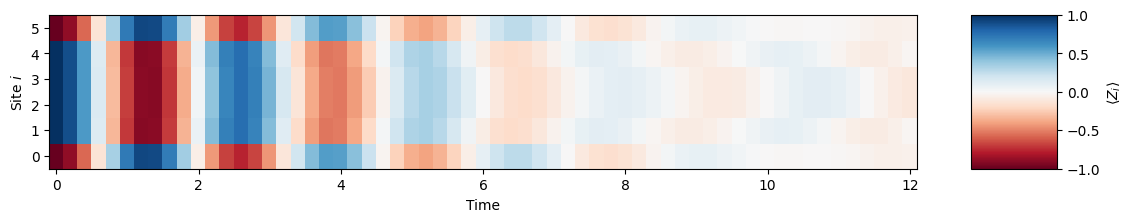

In [147]:
from matplotlib import cm

local_magnet = np.real(np.array(local_magnet_result))

plt.figure(figsize=(14, 2))
xx, yy = np.meshgrid(small_ts_vals, np.arange(L))
plt.pcolor(xx, yy, local_magnet.T, vmin=-1, vmax=+1, cmap="RdBu")
plt.yticks(np.arange(L))
plt.ylabel("Site $i$")
plt.xlabel("Time")
plt.colorbar(label="$\\langle Z_i \\rangle$", aspect=1.8)
plt.show()

Some question to tester (@Meijian):
1. Why is Energy constant, because initial state is eigenstate already?
2. Why does M damp and then bound back? so is C

### Open Questions

<div class="alert alert-block alert-warning">

**Further Questions**  
* Faster simulation with optimal trotter step size and trotter order, for example using *TrotterQRTE* class from *quantum_algorithm* module. See tutorial [here](https://qiskit-community.github.io/qiskit-algorithms/tutorials/13_trotterQRTE.html). Important note: on real quantum device, due to no-cloning theorem, one needs to restart the full evolution for any observable.
* Comparing with Classical Monte Carlo simulation using Metropolis Algorithm to observe phase transition at high and low temperature limits.
* Generalization to 2D Ising Model
* Generalization to finite temperature Ising Model evolution
</div>

## Part 2. Maximum Cut Problem

The well-known Maximum cut problem (or Maxcut problem) is stated as follows:

"Given a graph of n nodes, how do we cut the graph into two partitions such that the number of edges between the two partitions are maximized?"



<div>
    <img src="maxcut_problem.png" width=300>
</div>

This so-called Maxcut problem, is an NP-hard problem in general. It has excited many algorithms to calcuate its solution. In general, a bruteforce that enumerate all possible partitions will break down at large graph limit. People have dived into approximation algorithms to solve this combinatorial problem. It has become an important subfield in Discrete Mathematics.

With the advent of quantum computing, the Maxcut problem has been applied extensively using variational quantum algorithms and for some specific subfield of this interesting problem, the quantum approach is able to defeat the classical approach theoretically. 

Today, we will look at the formulation of a simplified Maxcut problem (i.e., no constraints, no edge weight, etc), and we will use one of the popular quantum simulation techniques, the variational quantum eigensolver, to solve it.

### 2.1. Play with the Maximum Cut Problem

We start by loading the networkx module and some helper functions...

In [111]:

# load helpful functions
def prepare_maxcut(n, edges):
    '''
    n: number of nodes in G
    edges: list of connected edge pairs in G, make sure edges are indexed from 0, 1, to (n-1)
    '''
    for ei, ej in edges:
        assert 0 <= ei < n and 0 <= ej < n, f"Invalid edges! Edge ({ei}, {ej}) is Not allowed in a {n}-node Graph."
    G = nx.Graph()
    G.add_nodes_from(np.arange(0, n, 1))
    G.add_edges_from(edges)
    pos = nx.shell_layout(G)  # fix plot position, more options see 
    return G, pos

def plot_maxcut(G, pos, colors=None):
    '''
    Plot the Maxcut problem instance
    '''
    if colors == None:
        colors = ["lightgray" for node in G.nodes()]
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=1000, alpha=1.0, ax=default_axes, pos=pos)
    nx.draw_networkx_edges(G, pos=pos)
    
def get_adj_matrix(G):
    '''
    Return an adjacency matrix of G, representing w_ij
    '''
    w = np.zeros([n, n])
    for i in range(n):
        for j in range(n):
            temp = G.get_edge_data(i, j, default=0)
            if temp != 0:
                w[i, j] = 1
    return w

def get_bruteforce_sol(G, verbose=False):
    '''
    Return the bruteforce solution for the adjacency matrix of a Maxcut graph.
    '''
    G_adj = get_adj_matrix(G)
    best_cost_brute = 0
    for b in range(2**n):
        # b = 0, x = [0, 0, 0, 0]
        # b = 1, x = [1, 0, 0, 0]
        # b = 2, x = [0, 1, 0, 0] ...
        x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
        cost = 0
        for i in range(n):
            for j in range(n):
                cost = cost + G_adj[i, j] * x[i] * (1 - x[j])
        if best_cost_brute < cost:
            best_cost_brute = cost
            xbest_brute = x
        if verbose: print("case = " + str(x) + " cost = " + str(cost))
    return xbest_brute, best_cost_brute

<div class="alert alert-block alert-success">

**Exercise 13. Get Familiar with Maxcut Problem**  
    
Play with these functions above 
- *prepare_maxcut*
- *plot_maxcut*
- *get_adj_matrix*
- *get_bruteforce_sol*
    
See if you can come up with an interesting Maxcut problem. 
    
Warning, be careful with the number of nodes, n, in the Graph. Your computer might crash if n is too big.

</div>

Adjacency matrix W = 
 [[0. 1. 0. 1.]
 [1. 0. 1. 0.]
 [0. 1. 0. 1.]
 [1. 0. 1. 0.]]


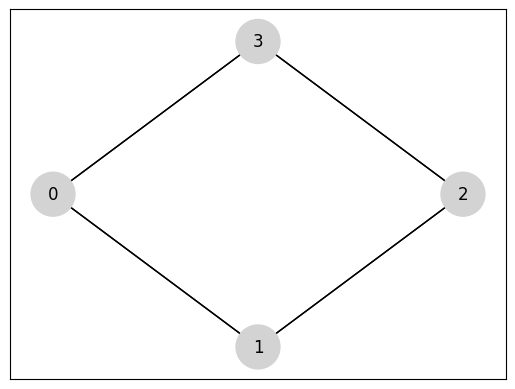

In [112]:
# Example 1.
n = 4
edges = [[0, 1], [1, 2], [2, 3], [3, 0]]
G, pos = prepare_maxcut(n, edges)
print("Adjacency matrix W = \n", get_adj_matrix(G))
plot_maxcut(G, pos)

case = [0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0] cost = 2.0
case = [0, 1, 0, 0] cost = 2.0
case = [1, 1, 0, 0] cost = 2.0
case = [0, 0, 1, 0] cost = 2.0
case = [1, 0, 1, 0] cost = 4.0
case = [0, 1, 1, 0] cost = 2.0
case = [1, 1, 1, 0] cost = 2.0
case = [0, 0, 0, 1] cost = 2.0
case = [1, 0, 0, 1] cost = 2.0
case = [0, 1, 0, 1] cost = 4.0
case = [1, 1, 0, 1] cost = 2.0
case = [0, 0, 1, 1] cost = 2.0
case = [1, 0, 1, 1] cost = 2.0
case = [0, 1, 1, 1] cost = 2.0
case = [1, 1, 1, 1] cost = 0.0

Best solution = [1, 0, 1, 0]  Maxcut cost = 4.0


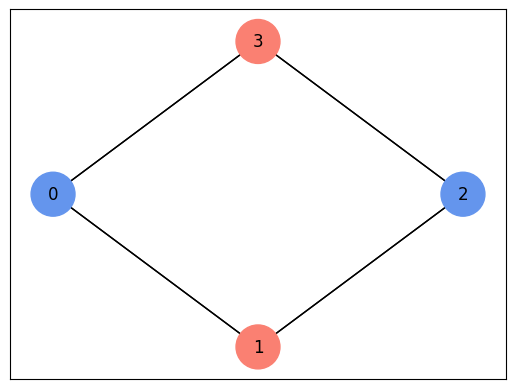

In [113]:
xbest_brute, best_cost_brute = get_bruteforce_sol(G, verbose=True)
print("\nBest solution = " + str(xbest_brute) + "  Maxcut cost = " + str(best_cost_brute))
colors = ["salmon" if xbest_brute[i] == 0 else "cornflowerblue" for i in range(n)]
plot_maxcut(G, pos, colors)

Adjacency matrix W = 
 [[0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 1. 0. 0.]
 [0. 1. 0. 1. 0. 0.]
 [1. 1. 1. 0. 1. 1.]
 [0. 0. 0. 1. 0. 1.]
 [1. 0. 0. 1. 1. 0.]]


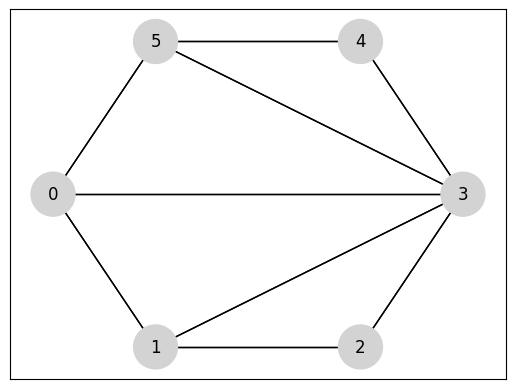

In [114]:
# Example 2.
n = 6
edges = [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 0], [3, 0], [1, 3], [3, 5]]
G, pos = prepare_maxcut(n, edges)
print("Adjacency matrix W = \n", get_adj_matrix(G))
plot_maxcut(G, pos)

case = [0, 0, 0, 0, 0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0, 0, 0, 0, 0] cost = 5.0
case = [0, 1, 0, 0, 0, 0, 0, 0] cost = 3.0
case = [1, 1, 0, 0, 0, 0, 0, 0] cost = 6.0
case = [0, 0, 1, 0, 0, 0, 0, 0] cost = 5.0
case = [1, 0, 1, 0, 0, 0, 0, 0] cost = 8.0
case = [0, 1, 1, 0, 0, 0, 0, 0] cost = 6.0
case = [1, 1, 1, 0, 0, 0, 0, 0] cost = 7.0
case = [0, 0, 0, 1, 0, 0, 0, 0] cost = 4.0
case = [1, 0, 0, 1, 0, 0, 0, 0] cost = 9.0
case = [0, 1, 0, 1, 0, 0, 0, 0] cost = 5.0
case = [1, 1, 0, 1, 0, 0, 0, 0] cost = 8.0
case = [0, 0, 1, 1, 0, 0, 0, 0] cost = 7.0
case = [1, 0, 1, 1, 0, 0, 0, 0] cost = 10.0
case = [0, 1, 1, 1, 0, 0, 0, 0] cost = 6.0
case = [1, 1, 1, 1, 0, 0, 0, 0] cost = 7.0
case = [0, 0, 0, 0, 1, 0, 0, 0] cost = 4.0
case = [1, 0, 0, 0, 1, 0, 0, 0] cost = 7.0
case = [0, 1, 0, 0, 1, 0, 0, 0] cost = 7.0
case = [1, 1, 0, 0, 1, 0, 0, 0] cost = 8.0
case = [0, 0, 1, 0, 1, 0, 0, 0] cost = 7.0
case = [1, 0, 1, 0, 1, 0, 0, 0] cost = 8.0
case = [0, 1, 1, 0, 1, 0, 0, 0] cost = 8.0
case = [1,

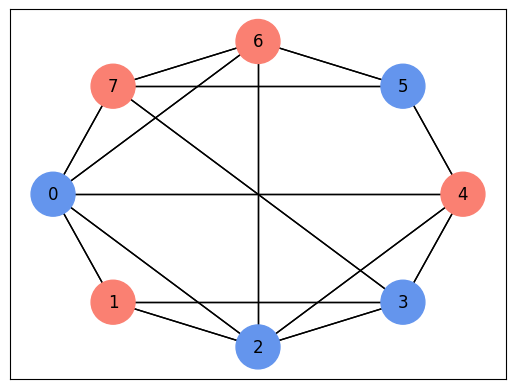

In [117]:
xbest_brute, best_cost_brute = get_bruteforce_sol(G, verbose=True)
print("\nBest solution = " + str(xbest_brute) + "  Maxcut cost = " + str(best_cost_brute))
colors = ["salmon" if xbest_brute[i] == 0 else "cornflowerblue" for i in range(n)]
plot_maxcut(G, pos, colors)

Best solution = [1, 0, 1, 1, 0, 1, 0, 0]  Maxcut cost = 13.0


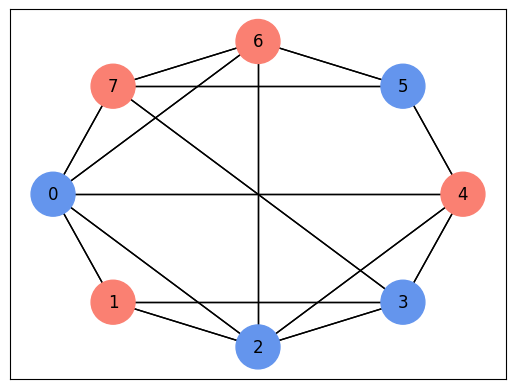

In [116]:
# Example 3.
n = 8
edges = [[i, i+1] for i in range(0, n-1)] + [[n-1, 0]]
edges += [[0, 2], [1, 3], [2, 4], [3, 7], [2, 6], [3,4], [6,7], [5,7], [0, 4], [0, 6]]
G, pos = prepare_maxcut(n, edges)
xbest_brute, best_cost_brute = get_bruteforce_sol(G)
print("Best solution = " + str(xbest_brute) + "  Maxcut cost = " + str(best_cost_brute))
colors = ["salmon" if xbest_brute[i] == 0 else "cornflowerblue" for i in range(n)]
plot_maxcut(G, pos, colors)

Did you come up with something more interesting?

### 2.2. The Maxcut Hamiltonian

<div class="alert alert-block alert-success">

**Exercise 14. Building the Maxcut Hamiltonian**  
    
From the lecture, we know the Maxcut Hamiltonian looks like,
    
$$    H = \sum_{ij} w_{ij}x_i(1-x_j) = \sum_{ij} w_{ij}\frac{I_i-Z_i}{2}\Big(I- \frac{I_j-Z_j}{2}\Big) = \sum_{i} c_{i} Z_i + \sum_{ij} d_{ij} Z_iZ_j$$
    
Use the helper function below (or come up with your own) to build the Hamiltonian for Maxcut.
    
Important to verify, your final, simplied Hamiltonian must only contain Pauli Z expressions.
</div>

In [118]:
# helpful functions
def get_x_op_at_i(i, n):
    ''' Return an operator x_i = (I_i - Z_i)/2 at specified qubit index i, with n qubits in total '''
    candidates = [I]*n
    candidates[i] = (I - Z)/2
    res = candidates[0]
    for i in range(1, n):
        res = res^candidates[i]
    return res

def get_I_op(n):
    ''' Return an identity operator over n qubits'''
    return SparsePauliOp(["I"*n], [1])

print(get_x_op_at_i(1, 4))
print(get_I_op(4))

SparsePauliOp(['IIII', 'IZII'],
              coeffs=[ 0.5+0.j, -0.5+0.j])
SparsePauliOp(['IIII'],
              coeffs=[1.+0.j])


In [119]:
def get_Hamiltonian_of_graph(G):
    '''
    Get Pauli-ZZ Hamiltonian for the adjacency matrix of a graph
    '''
    G_adj = get_adj_matrix(G)
    n = len(G_adj)
    Hamiltonian = 0

    for i in range(n):
        for j in range(n):
            if G_adj[i][j] != 0: # to speed up, avoid 0
                ##### ==================================
                # Write your solution in here.  
                # basically, you try to add all nonzero pauli terms to the Hamiltonian variable
                # each pauli term is a product of two pauli operator
                
                Hamiltonian = Hamiltonian + G_adj[i, j] * get_x_op_at_i(i, n) @ (get_I_op(n) - get_x_op_at_i(j, n))
                
                ##### ==================================
                
    Hamiltonian = Hamiltonian.simplify()  # simplify algebraic expression
    return Hamiltonian

SparsePauliOp(['IIII', 'ZZII', 'ZIIZ', 'IZZI', 'IIZZ'],
              coeffs=[ 2. +0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j])


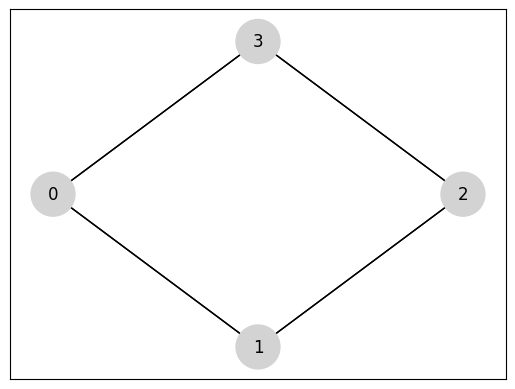

In [120]:
# Verification, Hamiltonian must contain only Pauli-Z
# Try start with a simple graph first, then move to a larger graph.
n = 4
edges = [[0, 1], [1, 2], [2, 3], [3, 0]]
G, pos = prepare_maxcut(n, edges)
H = get_Hamiltonian_of_graph(G)
print(H)
plot_maxcut(G, pos)

### 2.3. The Variational Quantum Eigensolver - Ansatz

Let us first quickly review what is the Variational Quantum Eigensolver (VQE). The VQE optimization loop consists of three essential parts

- Variational ansatz

- Quantum evolution and expectation evaluation, i.e. $\langle H \rangle = \langle \psi | H | \psi \rangle $
    
- Classical optimizer to update the next parameter, or exit the loop.

Instead of just calling some function from Qiskit, it is very important to know how to write the Vartional Quantum Eigensolver (VQE) from scratch. Here, we will help you to build your own VQE algorithm piece by piece.

The first task is to write a variational ansatz. This is probably the most diversified part of a VQE algorithm. One could implement this part like before using a time evolution of some Hamiltonian ansatz. Instead, we show you how to implement this using a heuristic variational circuit that is a good representation of the Hilbert space. 

For this part, we use the so-called Two-Local ansatz (available as *TwoLocal* class from Qiskit), where only adjacent qubit are connected (entangled). It is a commonly-used hardware-efficient ansatz, commonly used in quantum optimization problems.

In [121]:
from qiskit.circuit.library import TwoLocal

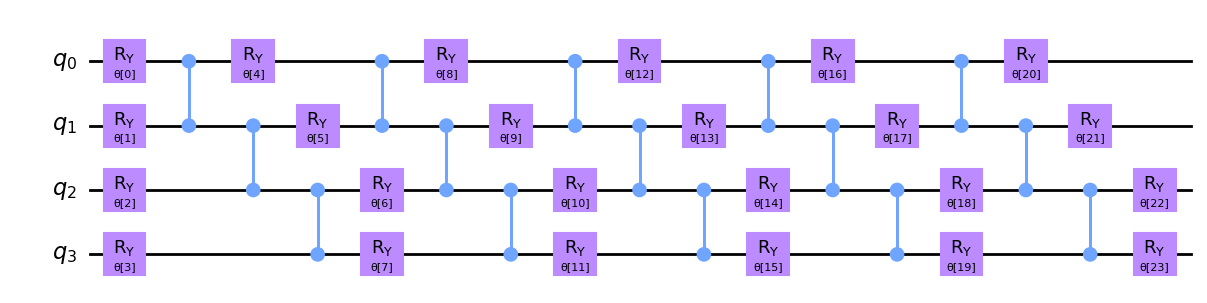

In [122]:
# An example on how to build 4-qubit TwoLocal ansatz with "ry" rotation gates, "cz" entanglement gates, and a depth of 5 repeated layers. 
# which is good starting place for us.
ansatz = TwoLocal(4, rotation_blocks=["ry"], entanglement_blocks=["cz"], reps=5, entanglement="linear")
ansatz.decompose().draw(output='mpl')

<div class="alert alert-block alert-success">

**Exercise 15. Vartional Quantum Eigensolver from Scratch, part 1**  
    
Looking at the example above and let's write a function to build our ansatz for a number of qubits $n$ and an arbitrary number of layers. You can keep the other function arguments same as the previous example.
    
</div>

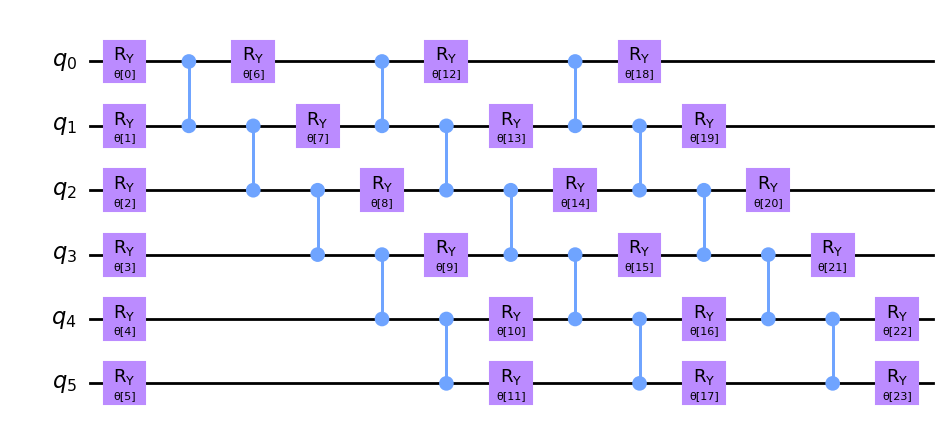

In [123]:
# build our own function using the example above 
def get_ansatz(n, layers):
    ##### ==================================
    # Write your solution in here.  
    ansatz = TwoLocal(n, "ry", "cz", reps=layers, entanglement="linear")
    ##### ==================================
    return ansatz

# test
get_ansatz(6, 3).decompose().draw(output='mpl')

### 2.4. The Variational Quantum Eigensolver - Cost Function

<div class="alert alert-block alert-success">

**Exercise 14. Vartional Quantum Eigensolver, part 2**  
    
We now look at the measuring the observable.
    
We write an *get_expectation* function to take in a variantional ansatz, a list of parameters, an observable, and a shot number. It returns the expectation value. 
    
Try take advantage of our own function *estimate_with_shots* defined earlier.
    
Note, the ansatz qubits and the observable qubits must be the identical.
        
</div>

In [124]:
def get_expectation(ansatz, params, observable, shots):
    assert ansatz.num_qubits == observable.num_qubits, f"ansatz qubits = {ansatz.num_qubits}, observable qubits = {observable.num_qubits}"
    ##### ==================================
    # Write your solution in here, you can use the method .bind_parameters() to inject parameters into the ansatz 
    circuit = ansatz.bind_parameters(params)
    expectation = estimate_with_shots(circuit, observable, shots)
    ##### ==================================
    return expectation

In [125]:
# test
# maxcut problem instance
n = 4
edges = [[0, 1], [1, 2], [2, 3], [3, 0]]
G, pos = prepare_maxcut(n, edges)

# building ansatz and observable
ansatz_ex = get_ansatz(n, 3)
parameters = [0.1]*ansatz_ex.num_parameters
observable = get_Hamiltonian_of_graph(G)

# expectation
get_expectation(ansatz_ex, parameters, observable, 1000)

0.2971776387369854

Note, your *get_expectation* function should return a value, which is the expectation value of quantum state generated by the ansatz. By tuning the parameters, you will see that this expectation value is different.

Essentially, the VQE algorithm finds the optimal parameter of the ansatz such that your expectation is minimizes. By the Variational Principle, when the expectation minimizes, our guess wavefunction approaches the ideal wavefunction.

In short, your ansatz with optimal parameters becomes your ideal wavefunction.

### 2.5. The Variational Quantum Eigensolver - Optimizer

<div class="alert alert-block alert-success">

**Exercise 16. Vartional Quantum Eigensolver, part 3**  
    
We now look at the last step, which is the optimization using classical optimizer, to complete our VQE function.
    
Our *vqe_from_scratch* takes a Maxcut problem instance G, a variational ansatz, and number of shots.
    
Specifically, we use Qiskit's *COBYLA* optimizers. Since *COBYLA* only has a *minimize* method, and we try to maximize the expectation observable (because it is called Maxcut!), we should evaluate $-\langle H \rangle$ in the *COBYLA.minimize* method. Maximum iterations, i.e., *maxiter*, should also be supplied.
        
To make results somewhat comparable, we add *random_seed* argument for initializing the parameter. However, simulation itself still involves randomness (a topic for another day).

There are a lot of optimizers you can use if you are interested, available in [qiskit.algorithms.optimizers](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.html). If you are using other classes, call_back functions need modify, see comments within.
</div>

In [126]:
from qiskit_algorithms.optimizers import COBYLA
# from qiskit.algorithms.optimizers import COBYLA # if last line does not work, use this one (but I recommend first line)

def maxcut_vqe_from_scratch(G, ansatz, shots, maxiter=300, random_seed=0, verbose=True):
    '''
    Our VQE from scratch for Maxcut problem G
    
    Return the VQE optimization result and its history
    
    '''
    
    # Helper function
    exp_val_list = []
    def callback(params):
        '''
        Callback to record expectation history and more!
           It is always optimizer dependent, so very tricky in general, for other optimizers, 
           you will need modify the argument to callback(num_eval, param, f_eval, step, acc) instead
        '''
        exp_val = get_expectation(ansatz, params, observable, shots)
        exp_val_list.append(exp_val)
        if verbose == True: print(f"step {len(exp_val_list):>4}:  <H> = {exp_val:>6.3f}")
    
    initial_parameters = [0.1]*ansatz_ex.num_parameters
    observable = get_Hamiltonian_of_graph(G)
    
    def minimize_func(params):
        ##### ==================================
        # Write your solution in here.     
        value_to_maximize = - get_expectation(ansatz, params, observable, shots)
        ##### ==================================
        return value_to_maximize

    np.random.seed(random_seed)
    initial_params = 0.1* np.random.random(ansatz.num_parameters)
    opt = COBYLA(maxiter=maxiter, callback=callback)
    
    res = opt.minimize(minimize_func, initial_params)
    
    return res, exp_val_list

In [127]:
# test
# maxcut problem instance
n = 4
edges = [[0, 1], [1, 2], [2, 3], [3, 0]]
G, pos = prepare_maxcut(n, edges)

# building ansatz and observable
ansatz = get_ansatz(n, 1)

# vqe
opt_res, exp_val_list = maxcut_vqe_from_scratch(G, ansatz, shots=1000)

step    1:  <H> =  0.588
step    2:  <H> =  1.050
step    3:  <H> =  1.371
step    4:  <H> =  1.596
step    5:  <H> =  2.207
step    6:  <H> =  2.314
step    7:  <H> =  2.557
step    8:  <H> =  2.626
step    9:  <H> =  2.366
step   10:  <H> =  2.667
step   11:  <H> =  2.468
step   12:  <H> =  2.845
step   13:  <H> =  2.416
step   14:  <H> =  2.744
step   15:  <H> =  2.751
step   16:  <H> =  2.899
step   17:  <H> =  3.176
step   18:  <H> =  3.217
step   19:  <H> =  3.190
step   20:  <H> =  3.437
step   21:  <H> =  3.526
step   22:  <H> =  3.725
step   23:  <H> =  3.375
step   24:  <H> =  3.788
step   25:  <H> =  3.857
step   26:  <H> =  3.915
step   27:  <H> =  3.908
step   28:  <H> =  3.750
step   29:  <H> =  3.936
step   30:  <H> =  3.720
step   31:  <H> =  3.794
step   32:  <H> =  3.844
step   33:  <H> =  3.779
step   34:  <H> =  3.956
step   35:  <H> =  3.973
step   36:  <H> =  3.967
step   37:  <H> =  3.948
step   38:  <H> =  3.982
step   39:  <H> =  3.988
step   40:  <H> =  3.966


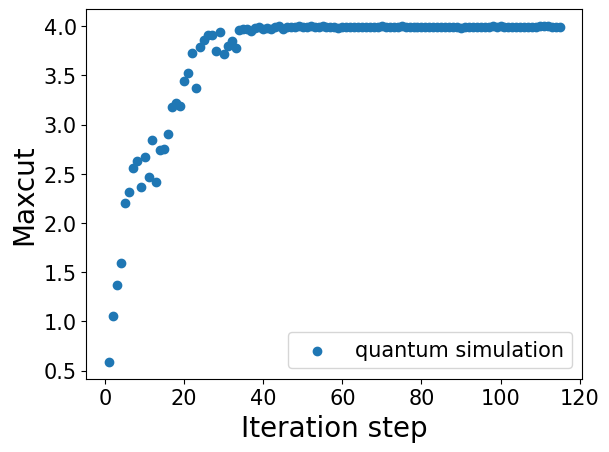

In [128]:
def plot_vqe_exp_val_list(exp_val_list, G=None):
    N = len(exp_val_list)
    xs = np.arange(1, N+1)
    plt.scatter(xs, exp_val_list, label='quantum simulation')
    plt.ylabel(r'Maxcut', fontsize=20)
    plt.xlabel('Iteration step', fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    if G != None:
        xBest, costBest = get_bruteforce_sol(G)
        plt.hlines(costBest, 0, N, ls='dashed', color='red', label='bruteforce')
    plt.legend(fontsize=15)
    plt.show()
    
# visualize result   
plot_vqe_exp_val_list(exp_val_list)

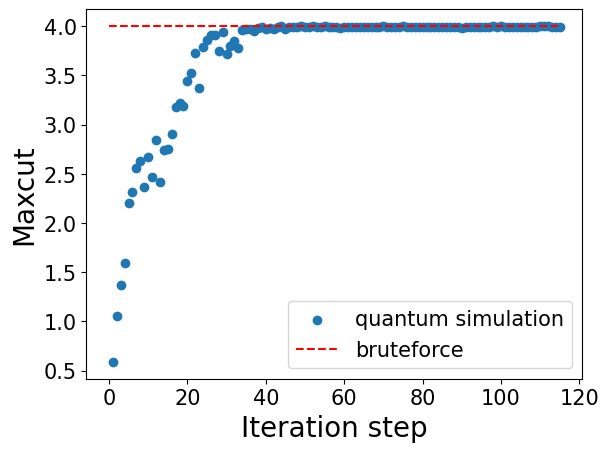

In [129]:
# visualize with bruteforce
plot_vqe_exp_val_list(exp_val_list, G)

If you see your simulation result agrees with the bruteforce as step increases, that indicates your algorithm is correct!

Big congratulations! You have implemented VQE from scratch, essentially.

### 2.6. Extract Maxcut Solution from Quantum Simulation 

<div class="alert alert-block alert-success">

**Exercise 17. Vartional Quantum Eigensolver, part 4**  
    
Hopefully your VQE optimization is working and you obtain the expected result with bruteforce calculation. Congratulations! It is a big step.
    
Now, you may wonder how do I know my optimal solution, i.e., the binary variable $x$? Afterall, we also need to know how to partition the graph, where the maximum cut is reached? 
    
The answer is you just need to sample the quantum state with your final, optimal parameters of the ansatz! Use your *sample_with_shots* or *sample_with_shots_v2* class defined before.
</div>

In [130]:
# your optimal parameters is in the x method of your opt_res object
opt_res.x

array([-0.05735609,  2.02589166, -0.007553  ,  1.65824565, -0.0838213 ,
        1.14047165,  0.03904018,  1.53691854])

In [136]:
def sample_probability_dist(ansatz, optimization_result, shots):
    ##### ==================================
    # Write your solution in here. 
    optimal_param = optimization_result.x
    qc = ansatz.bind_parameters(optimal_param)
    qc.measure_all()
    dist = sample_with_shots(qc, ansatz.num_qubits, shots)
    ##### ==================================
    return dist

In [137]:
def plot_probability_dist(dist):
    '''
    Convenience class to plot distribution
    '''
    if type(list(dist.keys())[0]) != str: # depend on your sample function
        new_dist = {}
        for k, v in dist.items():
            k = "".join([t for t in reversed(list(bin(k)[2:].zfill(n)))])
            new_dist[k] = v
        dist = new_dist
    
    return plot_histogram(dist)

{'1010': 0.9990234375, '1011': 0.0009765625}


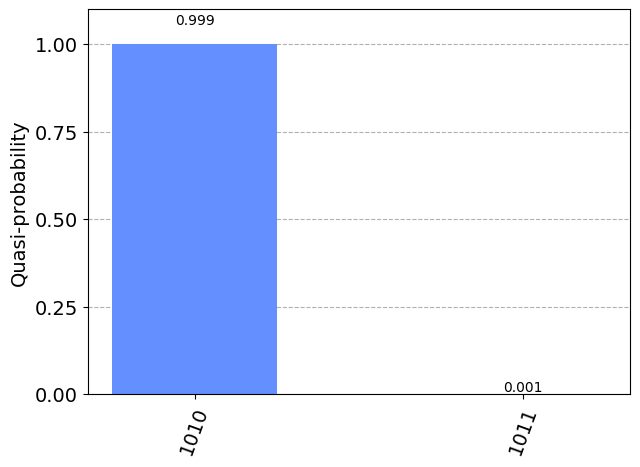

In [139]:
dist = sample_probability_dist(ansatz, opt_res, 1024)
print(dist)
plot_distribution(dist)

Note both 0101 and 1010 are correct solutions, because it does not matter if you call which one in partition which. It is just a label. So we literally achieved nearly 100 % accuracy!

Now, checking with bruteforce solution : )

Best solution = [1, 0, 1, 0]  Maxcut cost = 4.0


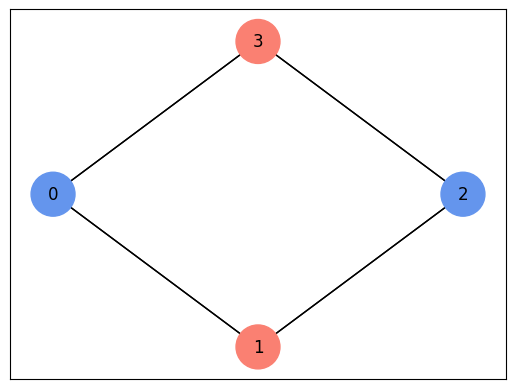

In [140]:
# cross check with bruteforce
xbest_brute, best_cost_brute = get_bruteforce_sol(G, verbose=False)
print("Best solution = " + str(xbest_brute) + "  Maxcut cost = " + str(best_cost_brute))
colors = ["salmon" if xbest_brute[i] == 0 else "cornflowerblue" for i in range(n)]
plot_maxcut(G, pos, colors)

### 2.7. Experiment with the Maxcut Problem

Now it is time to test your VQE algorithm on some randomly generated maxcut problems.


In [141]:
# You can use my function to generate a randomly hard maxcut graph
def prepare_random_maxcut(n, connectivity=0.3):
    '''
    Some hard maxcut graph generator, not an ideal one
    '''
    assert 0 <= connectivity < 1, "Connectivity is between 0 and 1"
    edges = []
    for i in range(n):
        for j in range(n):
            if i == j: continue
            e, re = [i, j], [j, i]
            if re in edges: continue # can be optimized with cache
            if np.random.random() < connectivity:
                edges.append(e)
    G, pos = prepare_maxcut(n, edges)
    return G, pos

Best solution = [1, 1, 1, 1, 0, 0, 0, 0, 0, 0]  Maxcut cost = 18.0


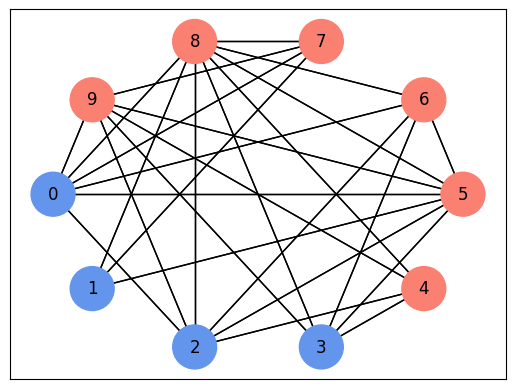

In [142]:
n = 10
G, pos = prepare_random_maxcut(n, 0.3)
xbest_brute, best_cost_brute = get_bruteforce_sol(G)
print("Best solution = " + str(xbest_brute) + "  Maxcut cost = " + str(best_cost_brute))
colors = ["salmon" if xbest_brute[i] == 0 else "cornflowerblue" for i in range(n)]
plot_maxcut(G, pos, colors)

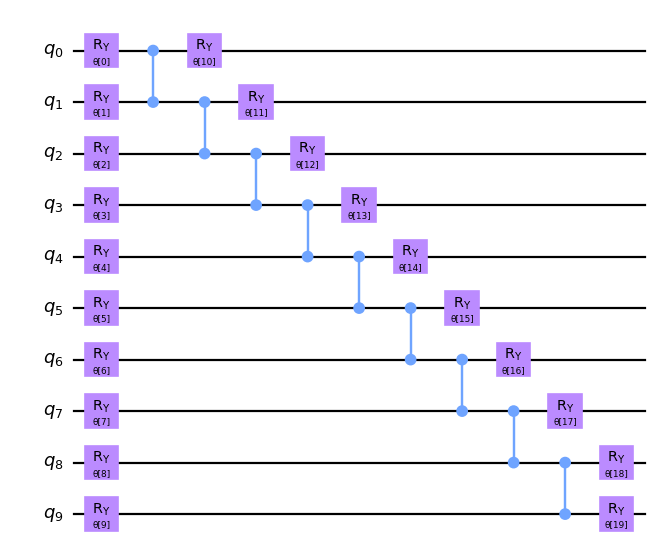

In [143]:
# building ansatz
ansatz = get_ansatz(n, 1)
ansatz.decompose().draw(scale=0.8, output='mpl')

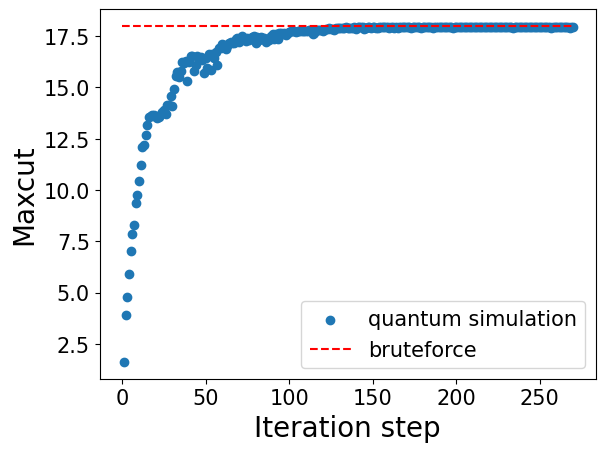

In [144]:
# vqe optimization
opt_res, exp_val_list = maxcut_vqe_from_scratch(G, ansatz, shots=3000, maxiter=500, random_seed=42, verbose=False)
plot_vqe_exp_val_list(exp_val_list, G)

### Open Questions

<div class="alert alert-block alert-warning">

**Further Questions**  
    
* Improve your VQE function to solve the Maxcut Problem
* Play with your *maxcut_vqe_from_scratch* on a more complicated Maxcut problem to see how it behaves! At some point, for some graph, the algorithm becomes insufficient, indicating the room for improvement such as the optimizer, expectation evaluations, etc. 

</div>